# Modelo predictivo de Fraudes - R5

**Contexto**

Los principales proyectos de R5 vienen encaminados al sector vehículos. Usted deberá apoyarse de sus conocimientos para cumplir el siguiente objetivo:

* **Reducir perdidas por fraude en las reclamaciones de siniestro**

In [112]:
import psycopg2

conn = psycopg2.connect(
    database="postgres",
    user='postgres',
    password='joseluis1',
    host='localhost',
    port= '5432'
    )

#Setting auto commit false
conn.autocommit = True

#Creating a cursor object using the cursor() method
cursor = conn.cursor()

#Retrieving data
cursor.execute('''SELECT * FROM public.fraudes''')

#Fetching 1st row from the table
result = cursor.fetchone();
#print(result)

#Fetching 1st row from the table
result = cursor.fetchall();
#print(result)

#Commit your changes in the database
conn.commit()

#Closing the connection
conn.close()

In [113]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import psycopg2

In [114]:
conn = psycopg2.connect(
    database="postgres",
    user='postgres',
    password='joseluis1',
    host='localhost',
    port= '5432'
    )

data_modeling = pd.read_sql_query('SELECT * FROM public.fraudes',con=conn)

In [115]:
data_modeling.head(5)

,monthh,weekofmonth,dayofweek,make,accidentarea,...,numberofsuppliments,addresschange_claim,numberofcars,yearr,basepolicy
0,Dec,5,Wednesday,Honda,Urban,...,none,1 year,3 to 4,1994,Liability
1,Jan,3,Wednesday,Honda,Urban,...,none,no change,1 vehicle,1994,Collision
2,Oct,5,Friday,Honda,Urban,...,none,no change,1 vehicle,1994,Collision
3,Jun,2,Saturday,Toyota,Rural,...,more than 5,no change,1 vehicle,1994,Liability
4,Jan,5,Monday,Honda,Urban,...,none,no change,1 vehicle,1994,Collision


In [116]:
data_modeling[['weekofmonth', 'weekofmonthclaimed','driverrating']] = data_modeling[['weekofmonth', 'weekofmonthclaimed','driverrating']].astype(str)

# Analisis Descriptivo

In [117]:
data_modeling.shape

(15420, 33)

In [118]:
data_modeling.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15420 entries, 0 to 15419
Data columns (total 33 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   monthh                15420 non-null  object
 1   weekofmonth           15420 non-null  object
 2   dayofweek             15420 non-null  object
 3   make                  15420 non-null  object
 4   accidentarea          15420 non-null  object
 5   dayofweekclaimed      15420 non-null  object
 6   monthclaimed          15420 non-null  object
 7   weekofmonthclaimed    15420 non-null  object
 8   sex                   15420 non-null  object
 9   maritalstatus         15420 non-null  object
 10  age                   15420 non-null  int64 
 11  fault                 15420 non-null  object
 12  policytype            15420 non-null  object
 13  vehiclecategory       15420 non-null  object
 14  vehicleprice          15420 non-null  object
 15  fraudfound_p          15420 non-null

In [119]:
categorical = data_modeling.select_dtypes(include='object').columns

In [120]:
#Aquí se calcula el número de categorías que tiene cada una de las variables categóricas consideradas en la base de datos
print('Número de Categorías por Variable')
data_modeling[categorical].apply(lambda x: len(x.unique())).reset_index(name='N_Levels').sort_values('N_Levels',ascending=False)

Número de Categorías por Variable


,index,N_Levels
3,make,19
6,monthclaimed,13
0,monthh,12
11,policytype,9
19,ageofpolicyholder,9
5,dayofweekclaimed,8
18,ageofvehicle,8
2,dayofweek,7
13,vehicleprice,6
7,weekofmonthclaimed,5


Con lo anterior se puede concluir que:
* La cantidad de ventas en el dataset son **1660725** la cual contiene para cada una un número determinado de productos solicitados por el cliente para un total de **12559901** regristros.
* La variable `Moneda` no presenta ninguna variación y su unico valor siempre es **COP**
* Dado que se tiene que la variable `Solic` que hace referencia al código del cliente, se puede inferir que hay un total de **80294** clientes en la base de datos.
* Se tienen **907** productos en la base de datos. (Es importante en este punto revisar si esta variable es de importancia y me pude entregar información referente a la fuga de los clientes, dada la cantidad de categorias se puede abordar de diferentes maneras para reducir el número de categorias en el analisis)

Procedimiento
0. Realizar entendimiento del problema y de las variables.
1. Construir la variable que identifique **Cliente Fugado**
2. Agrupar el Dataset de manera diaria (Venta) Cliente por Fecha
3. De lo anterior surge la creación de variables que agrupen la información de la base de datos (**Cantidad de productos comprados, Cantidad de areas involucradas en los productos vendidos, minimo de la cantidad de los productos comprados, maximo de la cantidad de los productos comprados, Total del valor de la venta**)
4. Analisis de variables (si merecen la pena ser consideradas).
5. Creación de algunas variables que pueden ser relevantes en el modelo.
6. Consolidación de la data.
7. Modelación.
8. Predicción
9. Comentarios

## Verificación Data

Text(0.5, 0, 'Fraude')

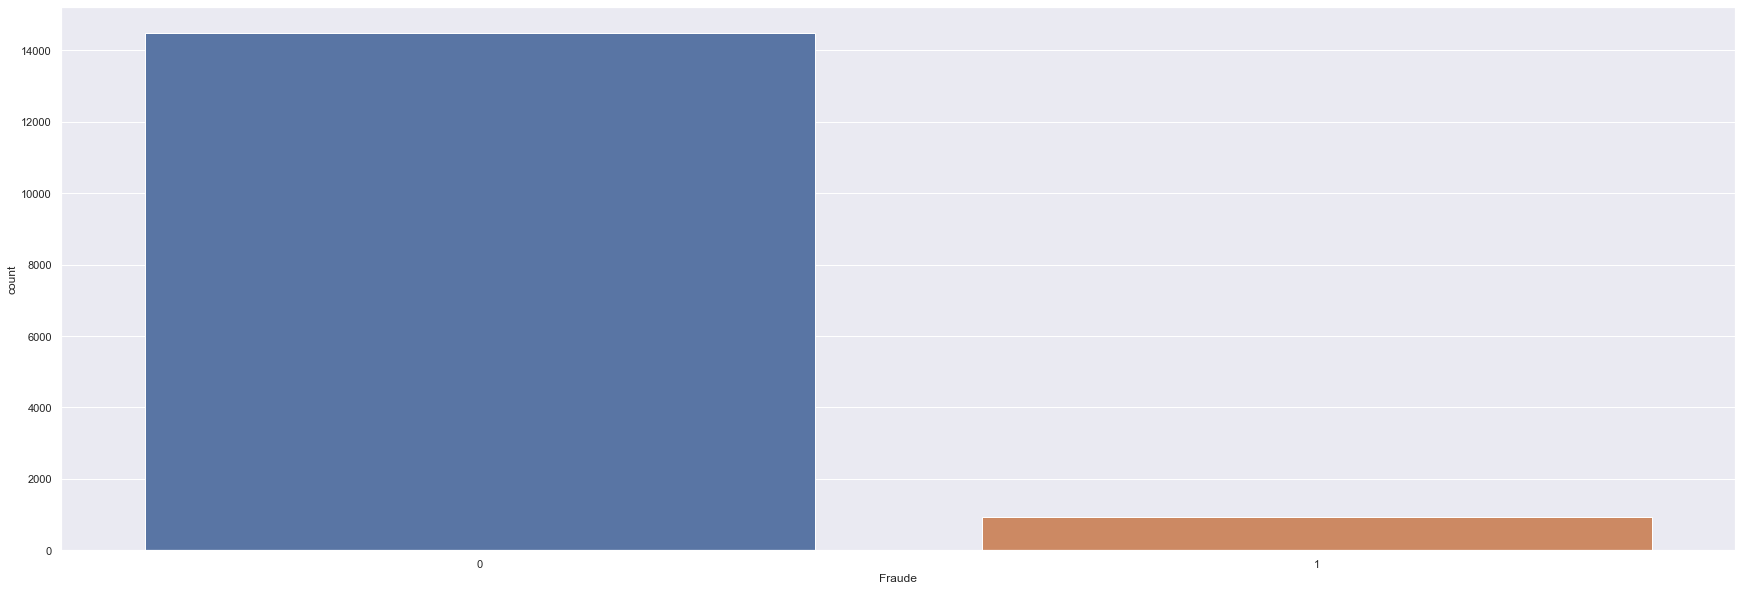

In [125]:
sns.set_theme(style="darkgrid")
sns.countplot(x="fraudfound_p", data=data_modeling)
plt.xlabel("Fraude")

In [10]:
Conteo=data_modeling[['fraudfound_p']].fillna('NA').value_counts().reset_index(name='Count')
Conteo['Total']=Conteo['Count'].sum()
Conteo['Porcentaje']=Conteo['Count']/Conteo['Total']*100
Conteo

,fraudfound_p,Count,Total,Porcentaje
0,0,14497,15420,94.014267
1,1,923,15420,5.985733


## Analisis Variables según Fraude

Text(0.5, 0, 'Fraude')

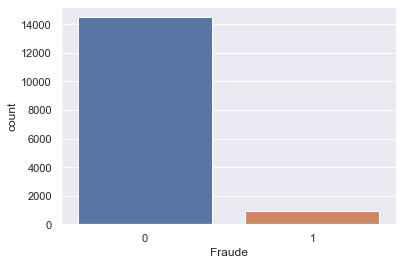

In [11]:
sns.set_theme(style="darkgrid")
sns.countplot(x="fraudfound_p", data=data_modeling)
plt.xlabel("Fraude")

Se tiene un total de 5.98% de fraudes del total de 15420 registros.

Acontinuación se analiza la información de fraudes  para cada una de las variables en consideración:

* Fraude vs `Month` (Mes en el que ocurrió el accidente)

In [126]:
Conteo=data_modeling[['monthh','fraudfound_p']].fillna('NA').value_counts().reset_index(name='Count')#.sort_values(['monthh', 'fraudfound_p'],ascending = [True, True])
Conteo['Total']=Conteo.groupby('monthh')['Count'].transform('sum')
Conteo['Porcentaje']=Conteo['Count']/Conteo['Total']*100
Conteo[Conteo['fraudfound_p']==1].sort_values(['Porcentaje'],ascending=False)

,monthh,fraudfound_p,Count,Total,Porcentaje
12,Mar,1,102,1360,7.500000
15,Aug,1,84,1127,7.453416
13,May,1,94,1367,6.876372
16,Feb,1,82,1266,6.477093
18,Apr,1,80,1280,6.250000
14,Jan,1,87,1411,6.165840
19,Sep,1,76,1240,6.129032
17,Jun,1,80,1321,6.056018
20,Oct,1,70,1305,5.363985
21,Dec,1,62,1285,4.824903


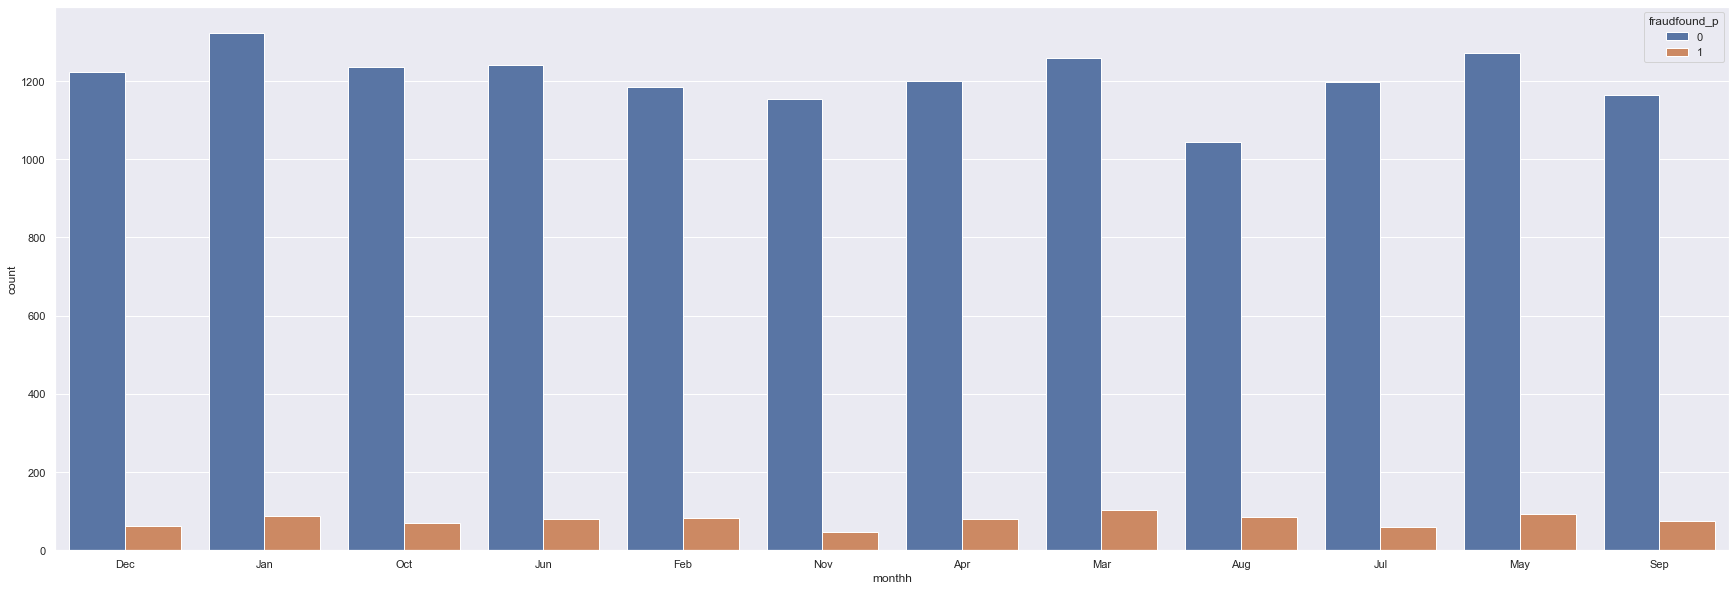

In [127]:
ax = sns.countplot(x="monthh", hue="fraudfound_p", data=data_modeling)

**El mayor porcentaje de fraudes se presenta en los meses de marzo y agosto:**

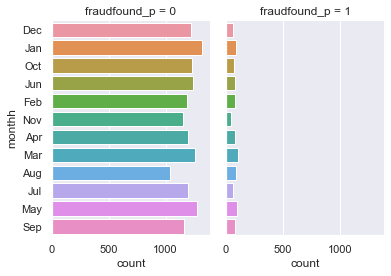

In [128]:
g = sns.catplot(y="monthh",col="fraudfound_p",
                data=data_modeling, kind="count",
                height=4, aspect=.7);

* Fraude vs `WeekOfMonth` (Semana en la que ocurrió el accidente)

In [129]:
Conteo=data_modeling[['weekofmonth','fraudfound_p']].fillna('NA').value_counts().reset_index(name='Count')#.sort_values(['weekofmonth', 'fraudfound_p'],ascending = [True, True])
Conteo['Total']=Conteo.groupby('weekofmonth')['Count'].transform('sum')
Conteo['Porcentaje']=Conteo['Count']/Conteo['Total']*100
Conteo[Conteo['fraudfound_p']==1].sort_values(['Porcentaje'],ascending=False)

,weekofmonth,fraudfound_p,Count,Total,Porcentaje
5,2,1,225,3558,6.323777
7,1,1,200,3187,6.275494
6,3,1,215,3640,5.906593
8,4,1,192,3398,5.650383
9,5,1,91,1637,5.558949


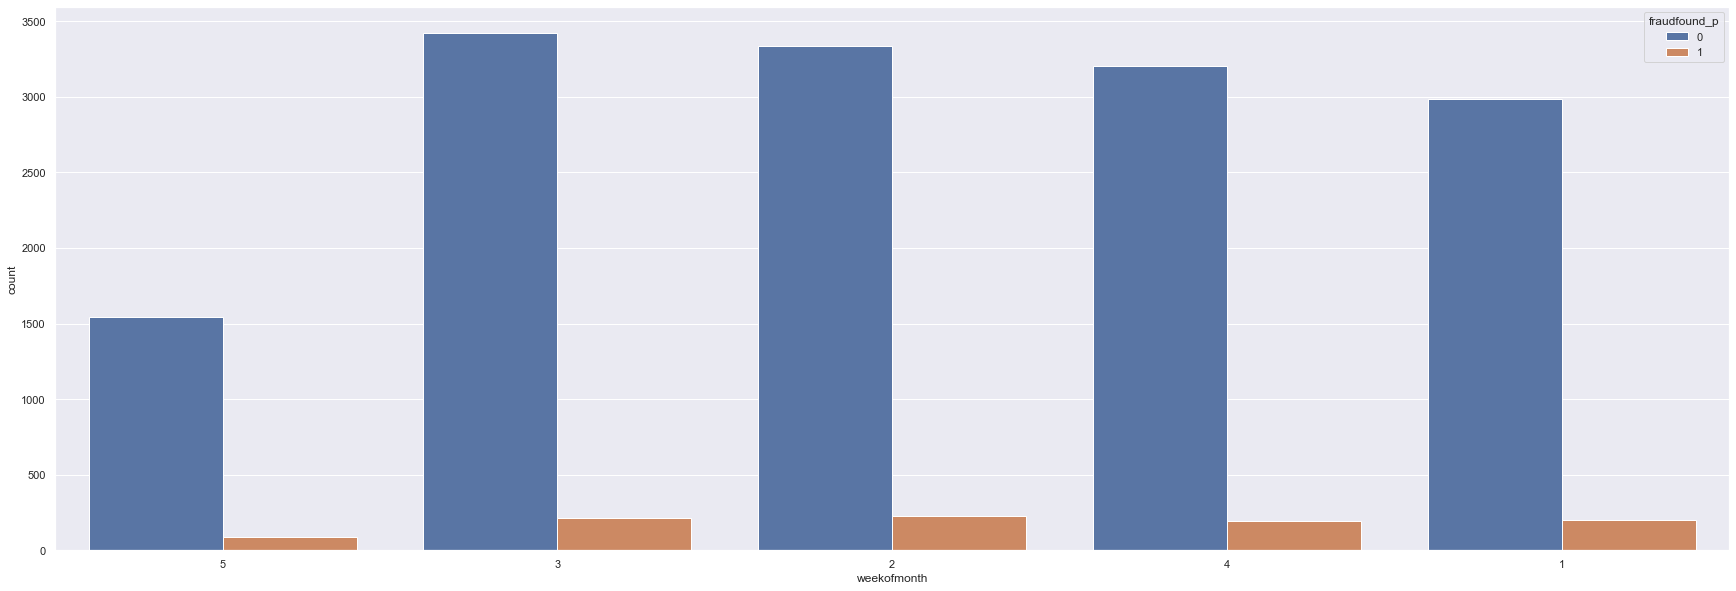

In [130]:
ax = sns.countplot(x="weekofmonth", hue="fraudfound_p", data=data_modeling)

* Fraude vs `DayOfWeek` (Día de la semana en que ocurrió el accidente)

In [131]:
Conteo=data_modeling[['dayofweek','fraudfound_p']].fillna('NA').value_counts().reset_index(name='Count')#.sort_values(['dayofweek', 'fraudfound_p'],ascending = [True, True])
Conteo['Total']=Conteo.groupby('dayofweek')['Count'].transform('sum')
Conteo['Porcentaje']=Conteo['Count']/Conteo['Total']*100
Conteo[Conteo['fraudfound_p']==1].sort_values(['Porcentaje'],ascending=False)

,dayofweek,fraudfound_p,Count,Total,Porcentaje
10,Sunday,1,122,1745,6.991404
9,Saturday,1,132,1982,6.659939
8,Friday,1,154,2445,6.298569
7,Monday,1,160,2616,6.116208
11,Thursday,1,120,2173,5.522319
13,Wednesday,1,115,2159,5.326540
12,Tuesday,1,120,2300,5.217391


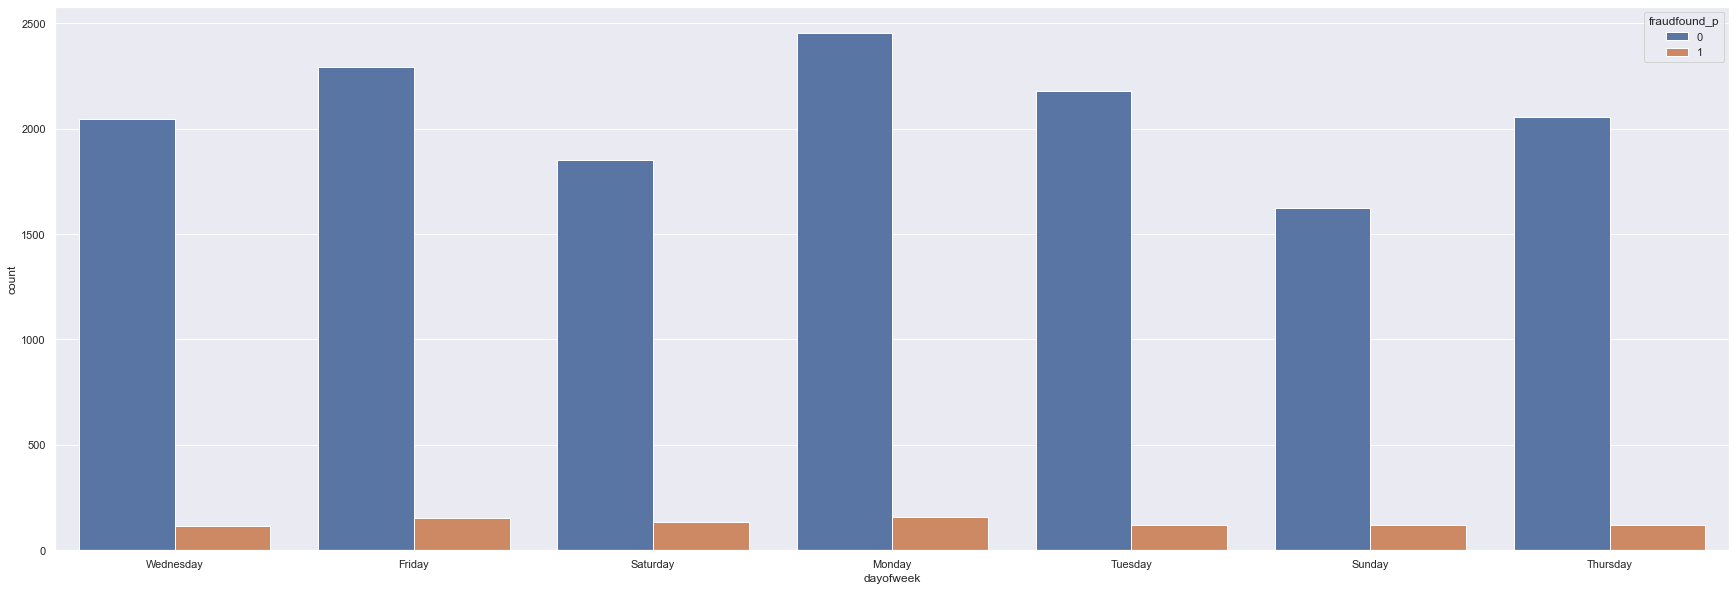

In [132]:
ax = sns.countplot(x="dayofweek", hue="fraudfound_p", data=data_modeling)

* Fraude vs `Make` (Marca del vehículo)

In [133]:
Conteo=data_modeling[['make','fraudfound_p']].fillna('NA').value_counts().reset_index(name='Count')#.sort_values(['make', 'fraudfound_p'],ascending = [True, True])
Conteo['Total']=Conteo.groupby('make')['Count'].transform('sum')
Conteo['Porcentaje']=Conteo['Count']/Conteo['Total']*100
Conteo[Conteo['fraudfound_p']==1].sort_values(['Porcentaje'],ascending=False)

,make,fraudfound_p,Count,Total,Porcentaje
31,Mecedes,1,1,4,25.000000
16,Accura,1,59,472,12.500000
25,Saturn,1,6,58,10.344828
21,Saab,1,11,108,10.185185
18,Ford,1,33,450,7.333333
23,Mercury,1,6,83,7.228916
33,BMW,1,1,15,6.666667
10,Honda,1,179,2801,6.390575
9,Toyota,1,186,3121,5.959628
14,Chevrolet,1,94,1681,5.591910


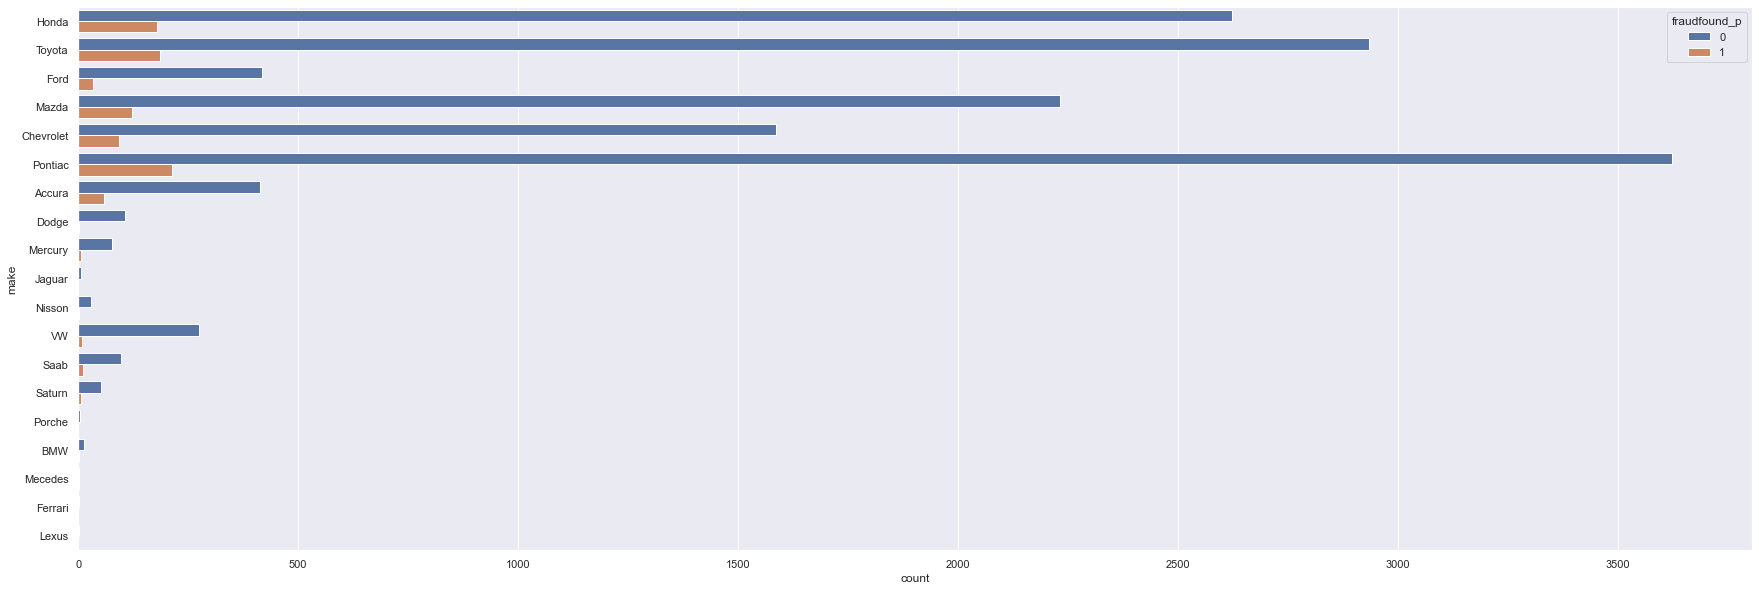

In [134]:
ax = sns.countplot(y="make", hue="fraudfound_p", data=data_modeling)

* Fraude vs `AccidentArea` (Si el accidente fue en un área rural o urbana)

In [135]:
Conteo=data_modeling[['accidentarea','fraudfound_p']].fillna('NA').value_counts().reset_index(name='Count')#.sort_values(['accidentarea', 'fraudfound_p'],ascending = [True, True])
Conteo['Total']=Conteo.groupby('accidentarea')['Count'].transform('sum')
Conteo['Porcentaje']=Conteo['Count']/Conteo['Total']*100
Conteo[Conteo['fraudfound_p']==1].sort_values(['Porcentaje'],ascending=False)

,accidentarea,fraudfound_p,Count,Total,Porcentaje
3,Rural,1,133,1598,8.322904
2,Urban,1,790,13822,5.715526


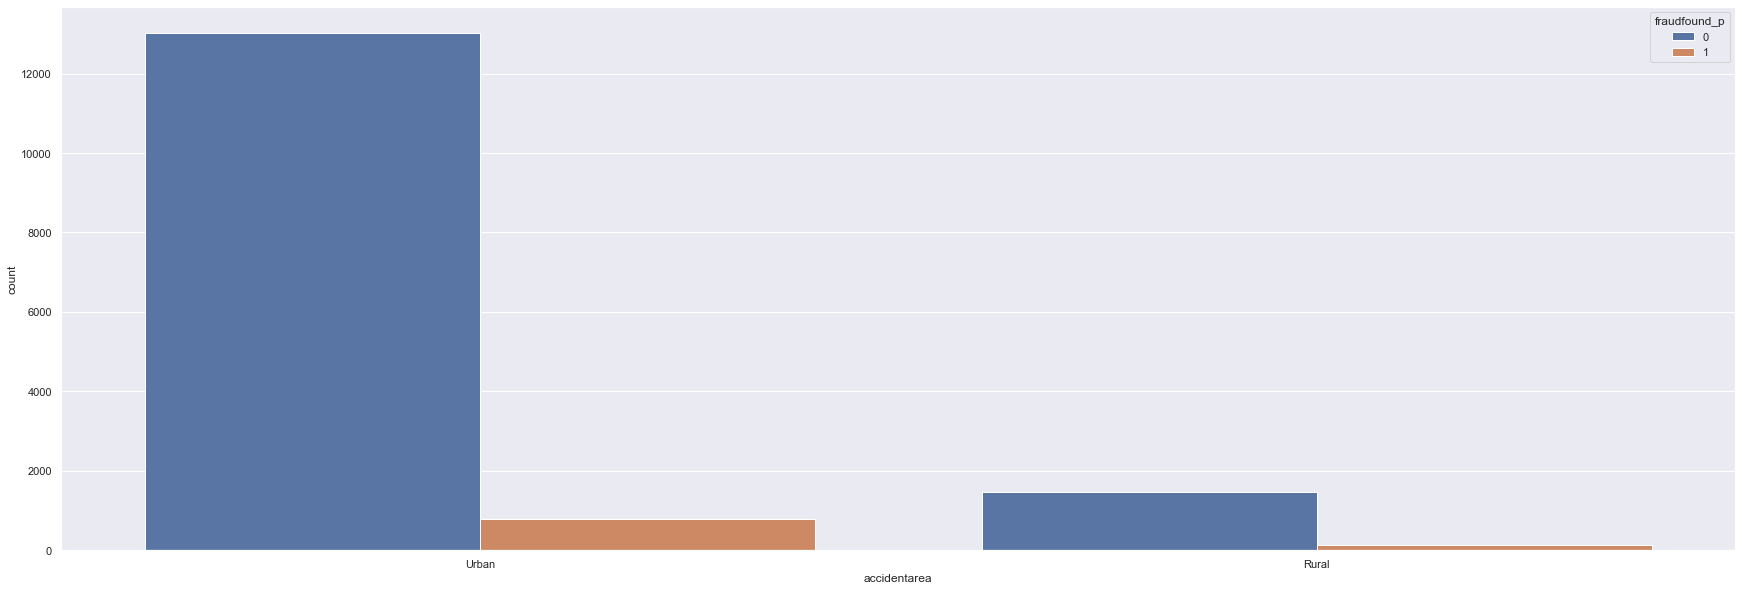

In [136]:
ax = sns.countplot(x="accidentarea", hue="fraudfound_p", data=data_modeling)

* Fraude vs `dayofweekclaimed` (Día de la semana en la que se hizo la denuncia, "controlar ceros")

In [137]:
Conteo=data_modeling[['dayofweekclaimed','fraudfound_p']].fillna('NA').value_counts().reset_index(name='Count')#.sort_values(['dayofweekclaimed', 'fraudfound_p'],ascending = [True, True])
Conteo['Total']=Conteo.groupby('dayofweekclaimed')['Count'].transform('sum')
Conteo['Porcentaje']=Conteo['Count']/Conteo['Total']*100
Conteo[Conteo['fraudfound_p']==1].sort_values(['Porcentaje'],ascending=False)

,dayofweekclaimed,fraudfound_p,Count,Total,Porcentaje
12,Saturday,1,10,127,7.874016
8,Friday,1,164,2497,6.567881
7,Wednesday,1,188,2951,6.370722
6,Tuesday,1,198,3375,5.866667
13,Sunday,1,3,52,5.769231
5,Monday,1,216,3757,5.749268
9,Thursday,1,144,2660,5.413534


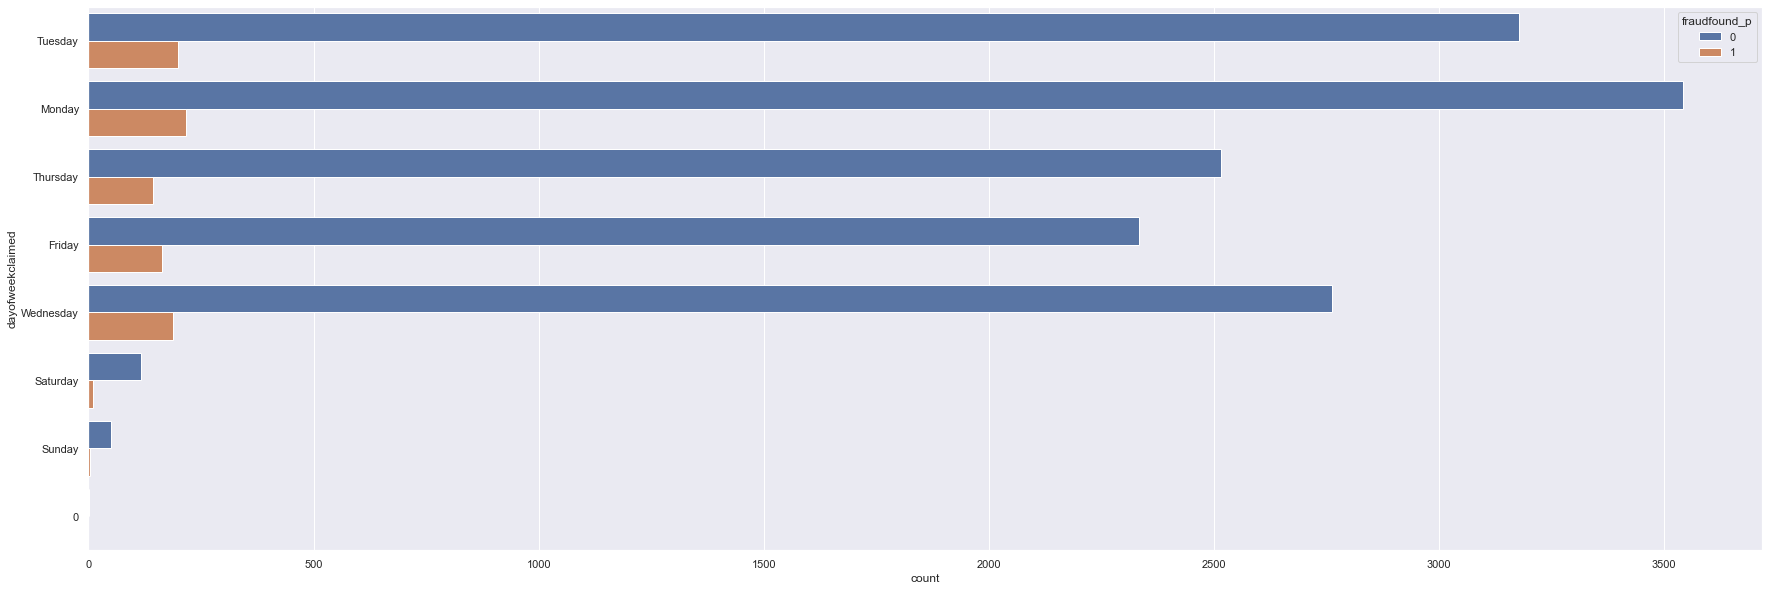

In [138]:
ax = sns.countplot(y="dayofweekclaimed", hue="fraudfound_p", data=data_modeling)

Valor erroneo en la variable `dayofweekclaimed` tomando un valor = 0

In [139]:
data_modeling.drop(data_modeling[data_modeling.dayofweekclaimed == "0"].index, inplace=True)

* Fraude vs `monthclaimed` (Mes en el que se hizo la denuncia, "controlar ceros")

In [140]:
Conteo=data_modeling[['monthclaimed','fraudfound_p']].fillna('NA').value_counts().reset_index(name='Count')#.sort_values(['monthclaimed', 'fraudfound_p'],ascending = [True, True])
Conteo['Total']=Conteo.groupby('monthclaimed')['Count'].transform('sum')
Conteo['Porcentaje']=Conteo['Count']/Conteo['Total']*100
Conteo[Conteo['fraudfound_p']==1].sort_values(['Porcentaje'],ascending=False)

,monthclaimed,fraudfound_p,Count,Total,Porcentaje
15,Aug,1,92,1126,8.170515
12,May,1,102,1411,7.228916
13,Mar,1,97,1348,7.195846
16,Apr,1,82,1271,6.451613
14,Jan,1,92,1446,6.362379
19,Sep,1,78,1242,6.280193
17,Feb,1,78,1287,6.060606
18,Jun,1,78,1293,6.032483
20,Oct,1,73,1339,5.451830
21,Jul,1,56,1225,4.571429


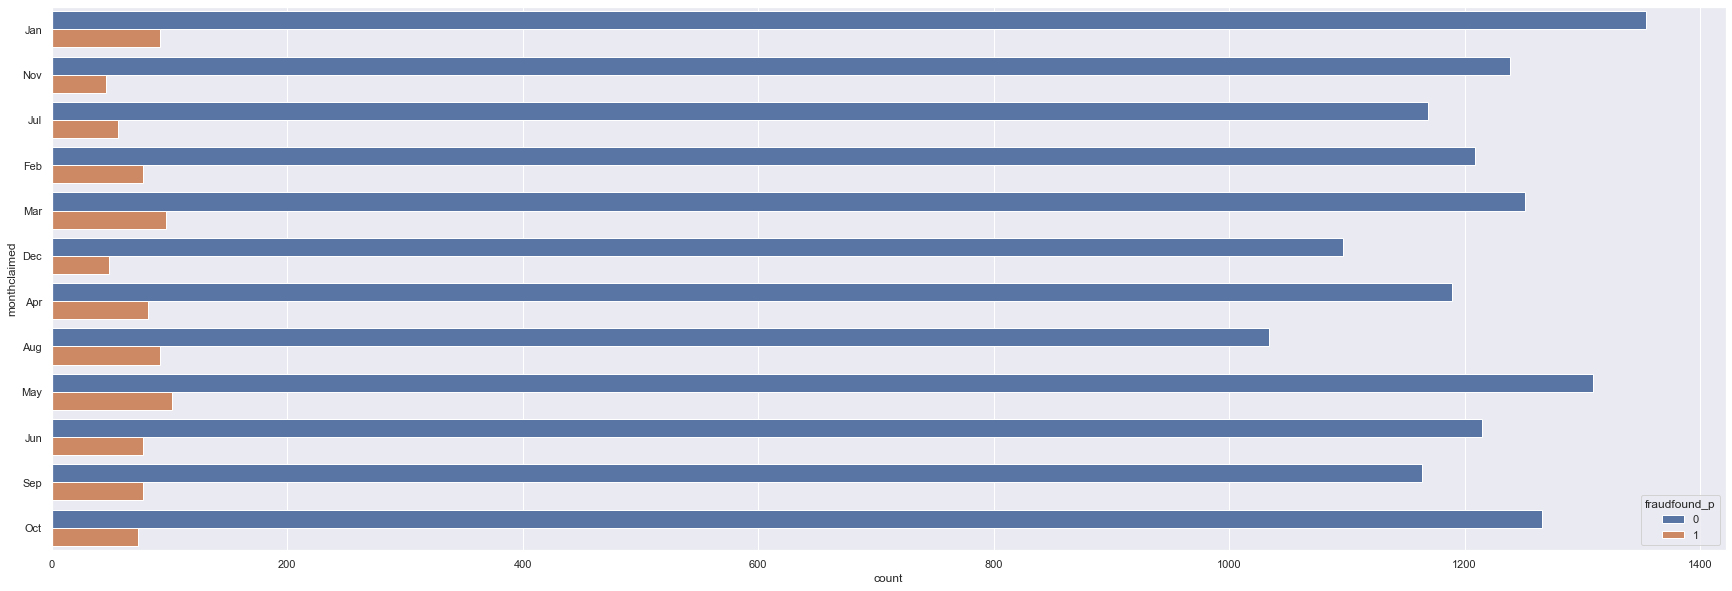

In [141]:
ax = sns.countplot(y="monthclaimed", hue="fraudfound_p", data=data_modeling)

* Fraude vs `weekofmonthclaimed` (Número de semana del mes en la que se hizo la denuncia)

In [142]:
Conteo=data_modeling[['weekofmonthclaimed','fraudfound_p']].fillna('NA').value_counts().reset_index(name='Count')#.sort_values(['weekofmonthclaimed', 'fraudfound_p'],ascending = [True, True])
Conteo['Total']=Conteo.groupby('weekofmonthclaimed')['Count'].transform('sum')
Conteo['Porcentaje']=Conteo['Count']/Conteo['Total']*100
Conteo[Conteo['fraudfound_p']==1].sort_values(['Porcentaje'],ascending=False)

,weekofmonthclaimed,fraudfound_p,Count,Total,Porcentaje
6,1,1,220,3449,6.378660
5,3,1,221,3583,6.168016
7,4,1,209,3433,6.087970
8,2,1,208,3720,5.591398
9,5,1,65,1234,5.267423


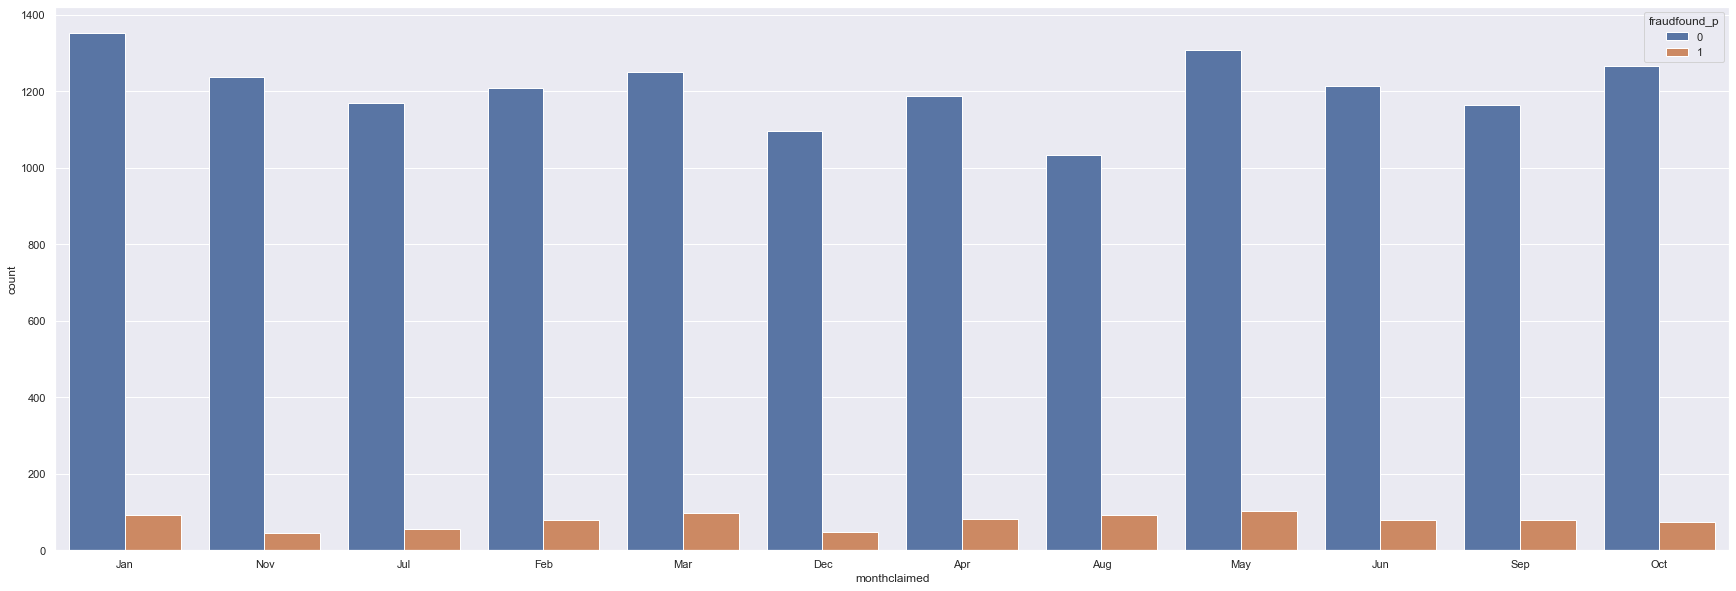

In [143]:
ax = sns.countplot(x="monthclaimed", hue="fraudfound_p", data=data_modeling)

* Fraude vs `sex` (Género de la persona que realiza la denuncia)

In [144]:
Conteo=data_modeling[['sex','fraudfound_p']].fillna('NA').value_counts().reset_index(name='Count')#.sort_values(['sex', 'fraudfound_p'],ascending = [True, True])
Conteo['Total']=Conteo.groupby('sex')['Count'].transform('sum')
Conteo['Porcentaje']=Conteo['Count']/Conteo['Total']*100
Conteo[Conteo['fraudfound_p']==1].sort_values(['Porcentaje'],ascending=False)

,sex,fraudfound_p,Count,Total,Porcentaje
2,Male,1,818,12999,6.292792
3,Female,1,105,2420,4.338843


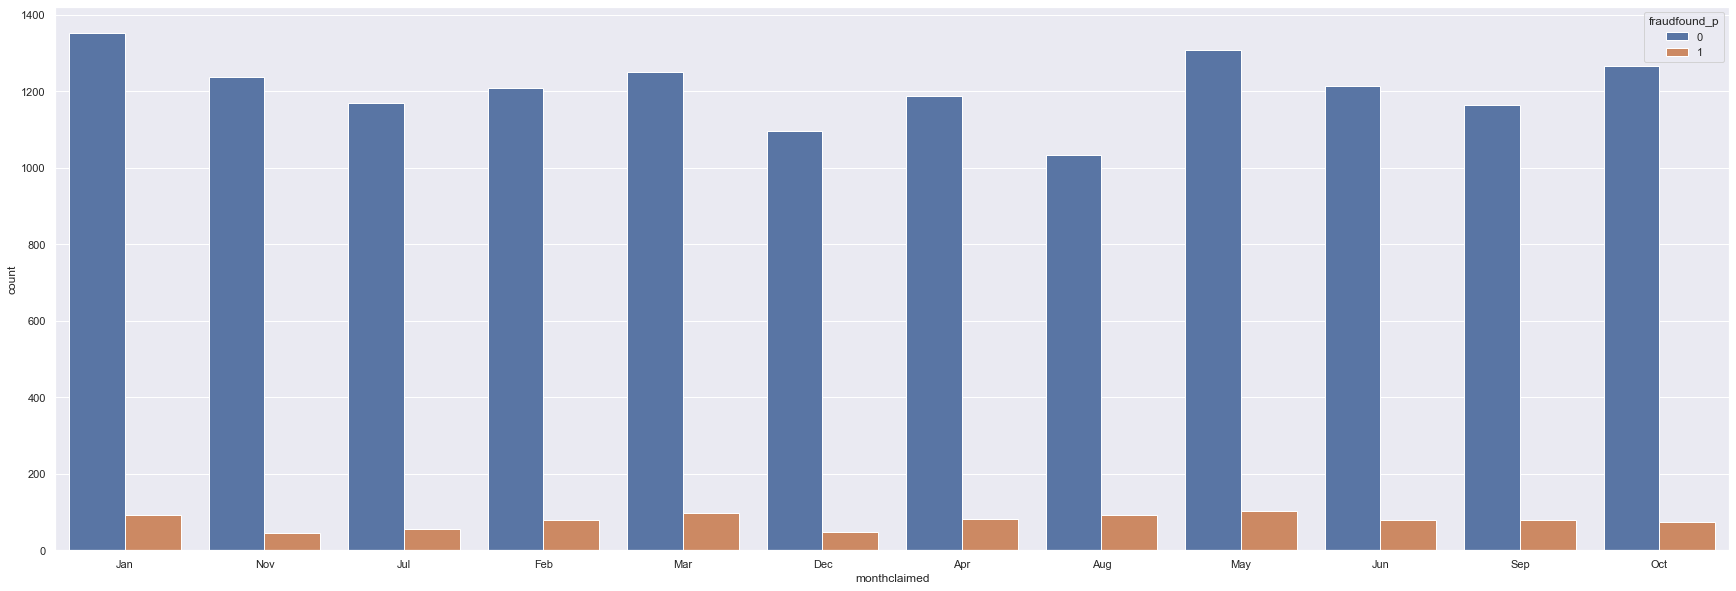

In [145]:
ax = sns.countplot(x="monthclaimed", hue="fraudfound_p", data=data_modeling)

* Fraude vs `maritalstatus` (Estado cívil de la persona que hace la denuncia)

In [146]:
Conteo=data_modeling[['maritalstatus','fraudfound_p']].fillna('NA').value_counts().reset_index(name='Count')#.sort_values(['maritalstatus', 'fraudfound_p'],ascending = [True, True])
Conteo['Total']=Conteo.groupby('maritalstatus')['Count'].transform('sum')
Conteo['Porcentaje']=Conteo['Count']/Conteo['Total']*100
Conteo[Conteo['fraudfound_p']==1].sort_values(['Porcentaje'],ascending=False)

,maritalstatus,fraudfound_p,Count,Total,Porcentaje
7,Widow,1,3,35,8.571429
2,Married,1,639,10625,6.014118
3,Single,1,278,4683,5.936366
6,Divorced,1,3,76,3.947368


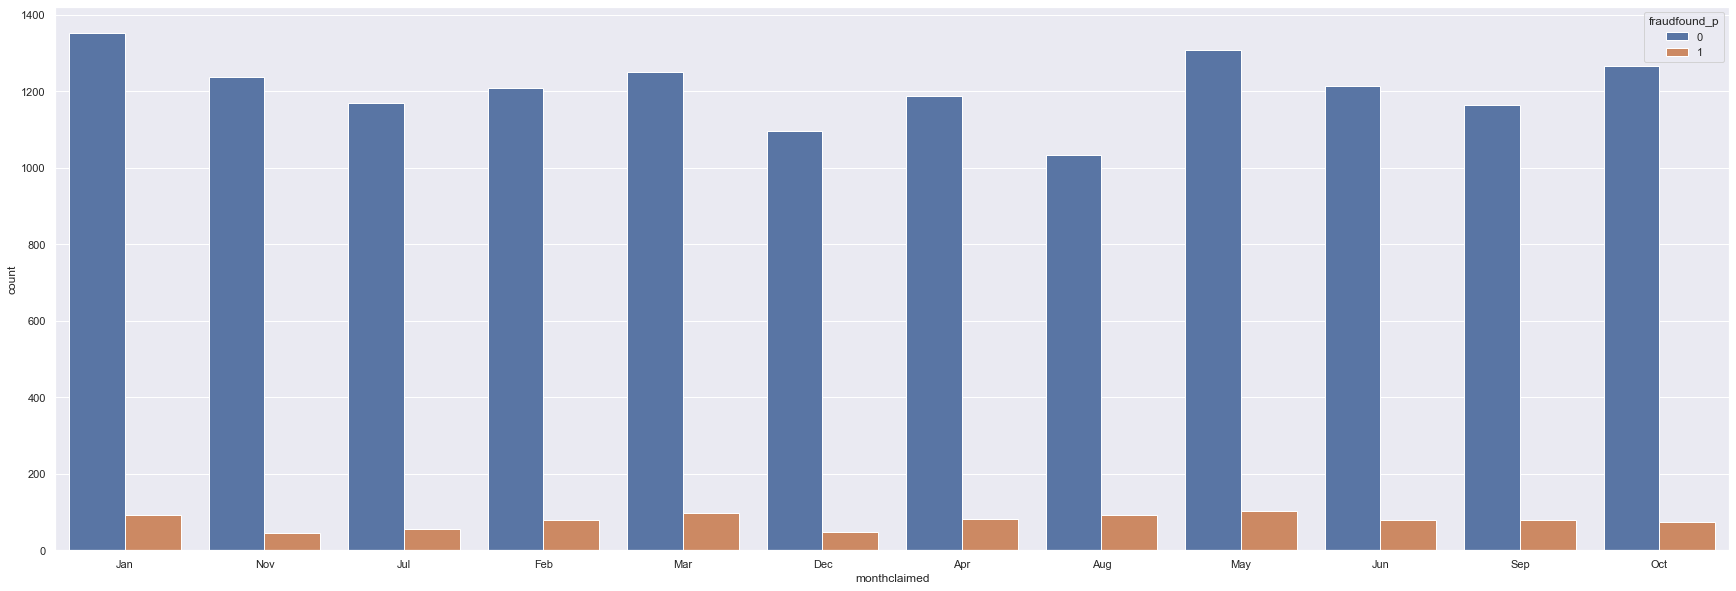

In [147]:
ax = sns.countplot(x="monthclaimed", hue="fraudfound_p", data=data_modeling)

* Fraude vs `Age` (Edad de la persona que hace la denuncia)

In [148]:
Conteo=data_modeling[['age','fraudfound_p']].fillna('NA').value_counts().reset_index(name='Count')#.sort_values(['age', 'fraudfound_p'],ascending = [True, True])
Conteo['Total']=Conteo.groupby('age')['Count'].transform('sum')
Conteo['Porcentaje']=Conteo['Count']/Conteo['Total']*100
Conteo[Conteo['fraudfound_p']==1].sort_values(['Porcentaje'],ascending=False)

,age,fraudfound_p,Count,Total,Porcentaje
100,18,1,8,48,16.666667
124,17,1,1,6,16.666667
112,19,1,5,32,15.625000
105,72,1,6,45,13.333333
113,67,1,4,31,12.903226
...,...,...,...,...,...
128,80,1,1,32,3.125000
122,74,1,1,35,2.857143
116,56,1,4,146,2.739726
99,47,1,8,308,2.597403


In [149]:

px.histogram(data_modeling, x='age', color="fraudfound_p", barmode='group')

Se debe tomar una desición al respecto de esta variable si eliminar o no la data con 0 en edad, o dejarlo como NA

En la edad se encuentran valores erroneos con valor de **0**

* Fraude vs `fault` (Si el culpable fue el dueño del seguro u otro involucrado)

In [150]:
Conteo=data_modeling[['fault','fraudfound_p']].fillna('NA').value_counts().reset_index(name='Count')#.sort_values(['fault', 'fraudfound_p'],ascending = [True, True])
Conteo['Total']=Conteo.groupby('fault')['Count'].transform('sum')
Conteo['Porcentaje']=Conteo['Count']/Conteo['Total']*100
Conteo[Conteo['fraudfound_p']==1].sort_values(['Porcentaje'],ascending=False)

,fault,fraudfound_p,Count,Total,Porcentaje
2,Policy Holder,1,886,11229,7.890284
3,Third Party,1,37,4190,0.883055


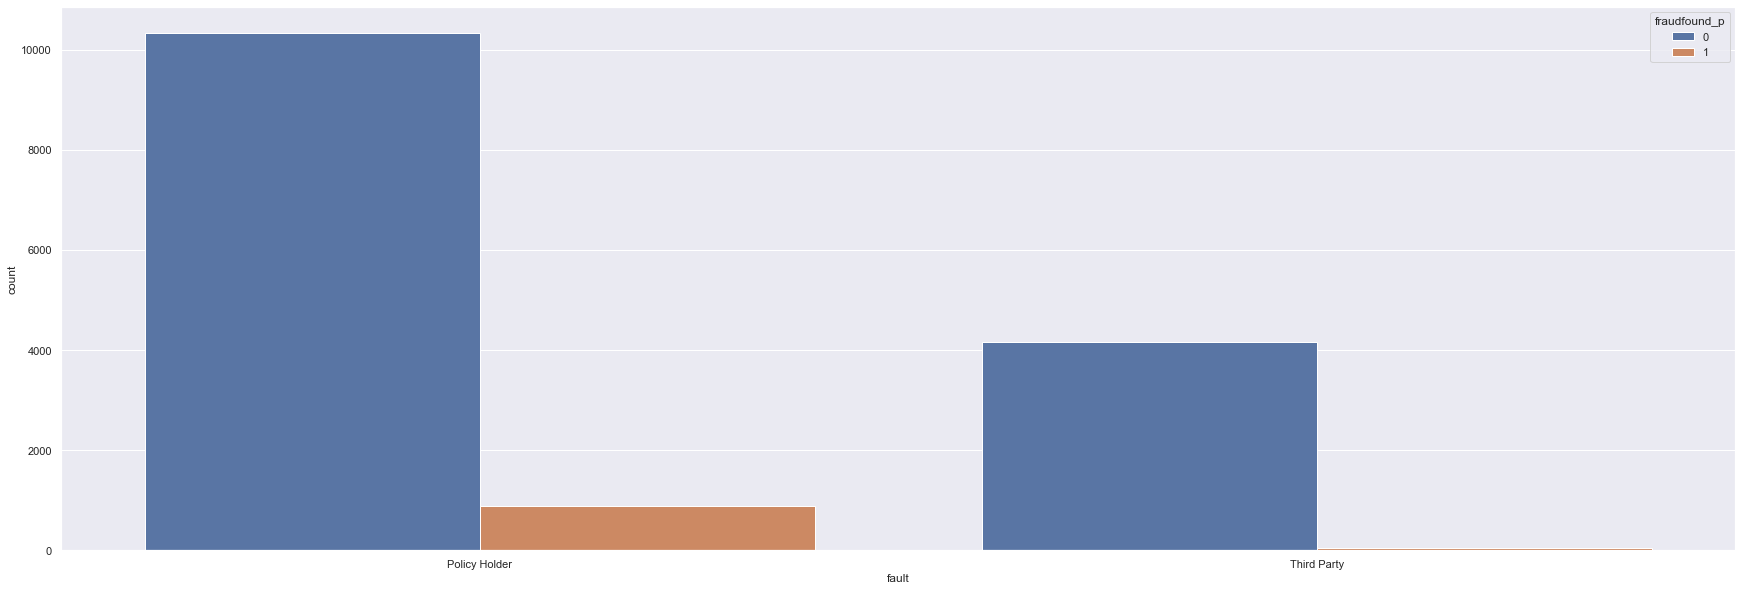

In [151]:
ax = sns.countplot(x="fault", hue="fraudfound_p", data=data_modeling)

* Fraude vs `policytype` (Combinación de tipo de auto y de tipo de póliza: Liability (contra terceros), Collision (Incluye daños al vehículo del propietario))

In [152]:
Conteo=data_modeling[['policytype','fraudfound_p']].fillna('NA').value_counts().reset_index(name='Count')#.sort_values(['policytype', 'fraudfound_p'],ascending = [True, True])
Conteo['Total']=Conteo.groupby('policytype')['Count'].transform('sum')
Conteo['Porcentaje']=Conteo['Count']/Conteo['Total']*100
Conteo[Conteo['fraudfound_p']==1].sort_values(['Porcentaje'],ascending=False)

,policytype,fraudfound_p,Count,Total,Porcentaje
7,Sport - Collision,1,48,348,13.793103
8,Utility - All Perils,1,41,340,12.058824
3,Sedan - All Perils,1,411,4086,10.058737
13,Utility - Collision,1,3,30,10.000000
4,Sedan - Collision,1,384,5584,6.876791
9,Sedan - Liability,1,36,4987,0.721877


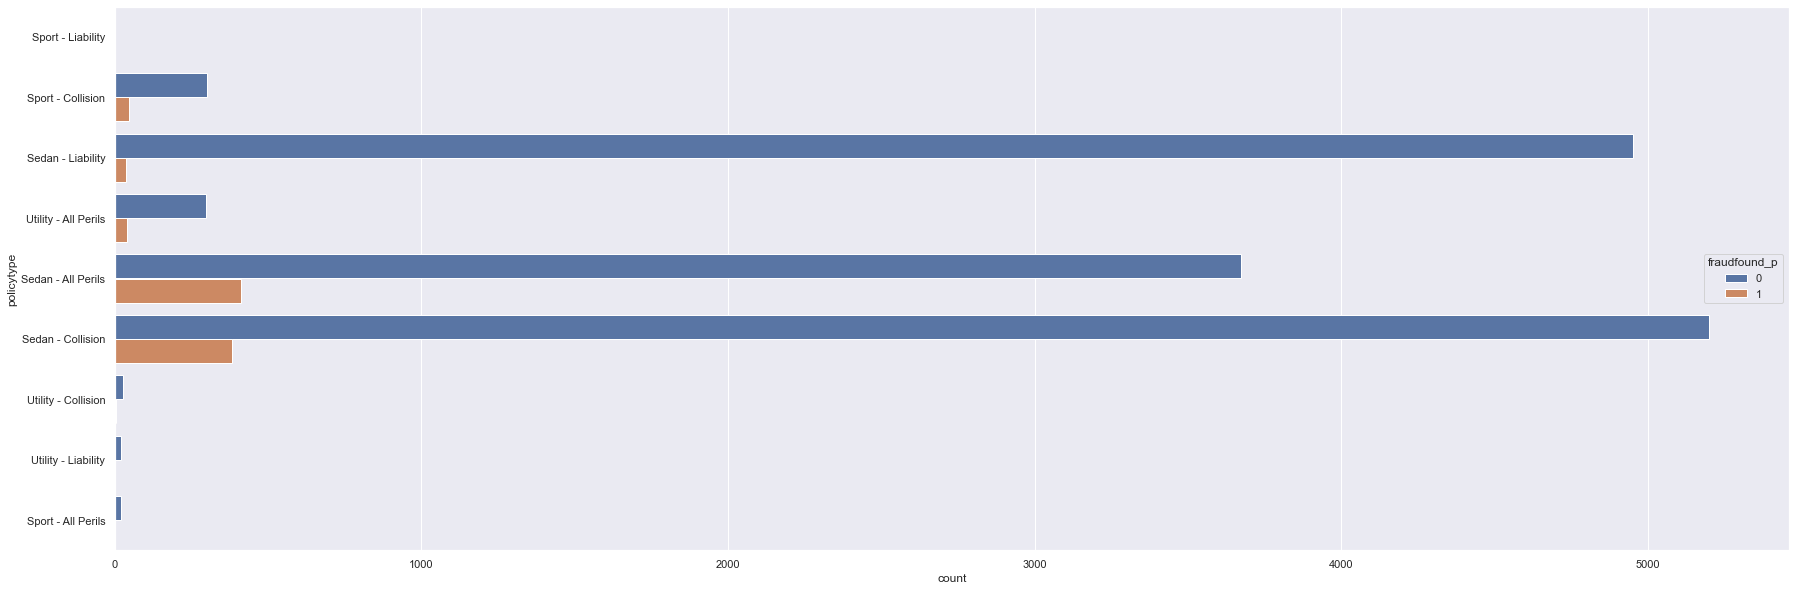

In [153]:
ax = sns.countplot(y="policytype", hue="fraudfound_p", data=data_modeling)

Interesante observar que la mayoria de los fraudes han ocurrido en las categorias:
* Sedan - All Perils
* Sedan - Collision

En donde estas tienen cantidad de eventos similares a Sedan - Liability	

* Fraude vs `VehicleCatergory` ( Clasificación de tipo de auto)

In [154]:
Conteo=data_modeling[['vehiclecategory','fraudfound_p']].fillna('NA').value_counts().reset_index(name='Count')#.sort_values(['vehiclecategory', 'fraudfound_p'],ascending = [True, True])
Conteo['Total']=Conteo.groupby('vehiclecategory')['Count'].transform('sum')
Conteo['Porcentaje']=Conteo['Count']/Conteo['Total']*100
Conteo[Conteo['fraudfound_p']==1].sort_values(['Porcentaje'],ascending=False)

,vehiclecategory,fraudfound_p,Count,Total,Porcentaje
5,Utility,1,44,391,11.253197
2,Sedan,1,795,9670,8.221303
4,Sport,1,84,5358,1.567749


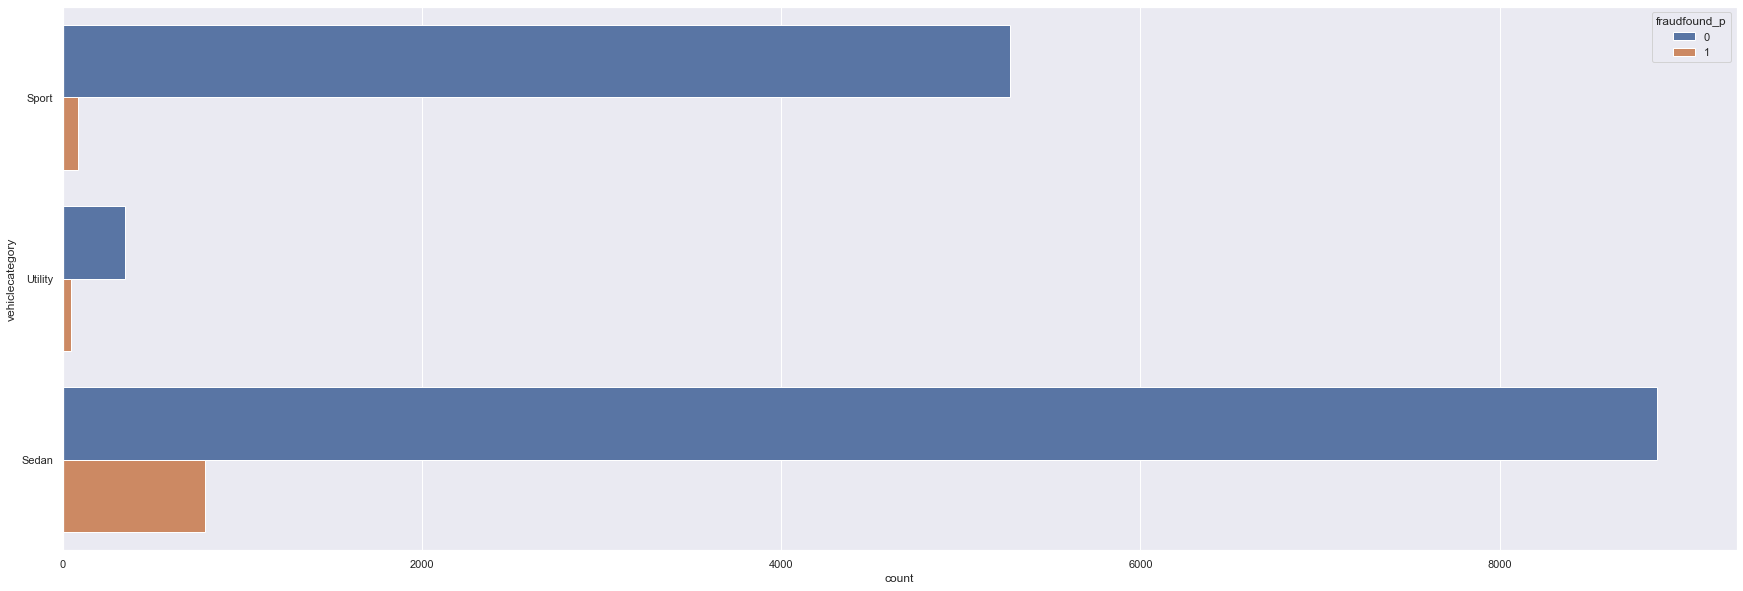

In [155]:
ax = sns.countplot(y="vehiclecategory", hue="fraudfound_p", data=data_modeling)

* Fraude vs `VehiclePrice` (Precio del vehículo)

In [156]:
Conteo=data_modeling[['vehicleprice','fraudfound_p']].fillna('NA').value_counts().reset_index(name='Count')#.sort_values(['vehicleprice', 'fraudfound_p'],ascending = [True, True])
Conteo['Total']=Conteo.groupby('vehicleprice')['Count'].transform('sum')
Conteo['Porcentaje']=Conteo['Count']/Conteo['Total']*100
Conteo[Conteo['fraudfound_p']==1].sort_values(['Porcentaje'],ascending=False)

,vehicleprice,fraudfound_p,Count,Total,Porcentaje
8,less than 20000,1,103,1096,9.397810
6,more than 69000,1,189,2163,8.737864
10,40000 to 59000,1,31,461,6.724512
5,20000 to 29000,1,421,8079,5.211041
7,30000 to 39000,1,175,3533,4.953297
11,60000 to 69000,1,4,87,4.597701


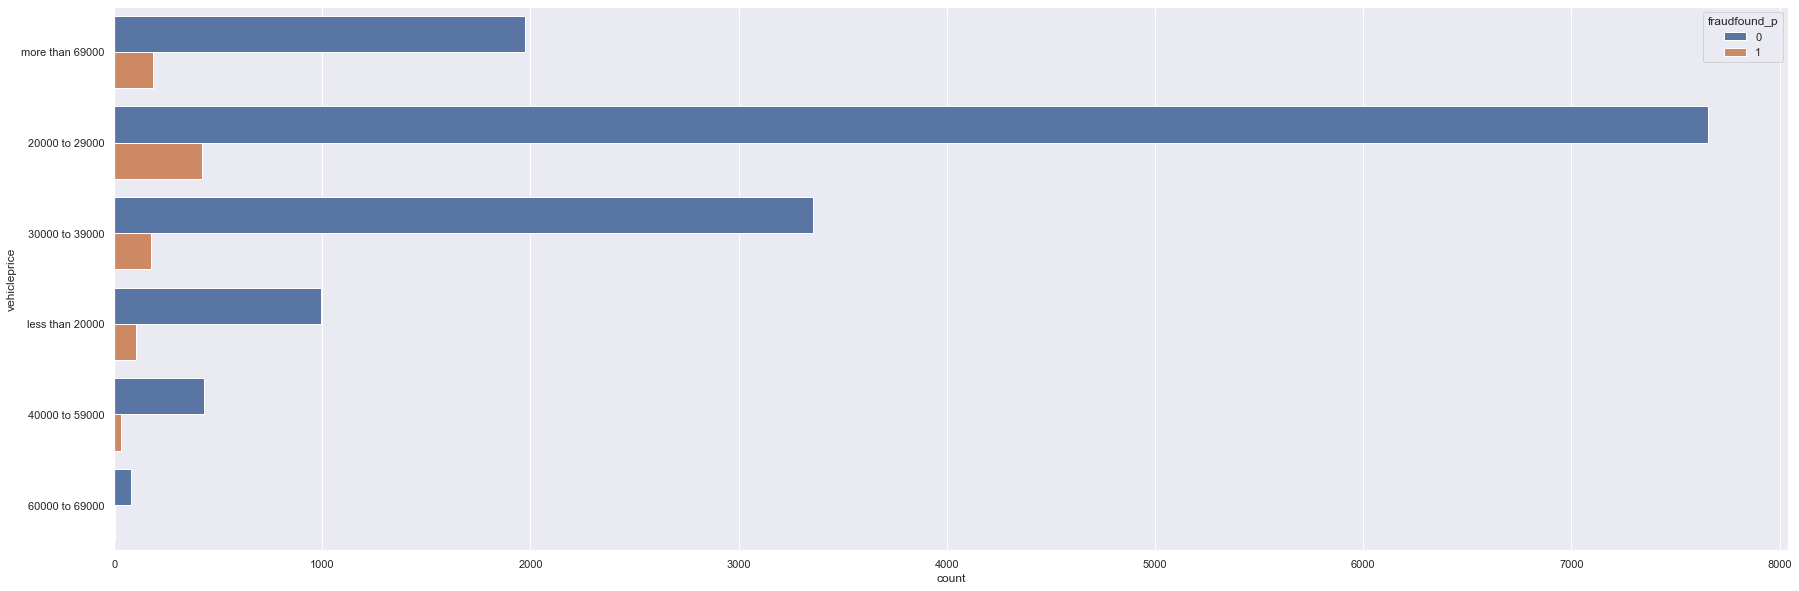

In [157]:
ax = sns.countplot(y="vehicleprice", hue="fraudfound_p", data=data_modeling)

* Fraude vs `repnumber` (Numeración entre 1 y 16)

In [158]:
Conteo=data_modeling[['repnumber','fraudfound_p']].fillna('NA').value_counts().reset_index(name='Count')#.sort_values(['repnumber', 'fraudfound_p'],ascending = [True, True])
Conteo['Total']=Conteo.groupby('repnumber')['Count'].transform('sum')
Conteo['Porcentaje']=Conteo['Count']/Conteo['Total']*100
Conteo[Conteo['fraudfound_p']==1].sort_values(['Porcentaje'],ascending=False)

,repnumber,fraudfound_p,Count,Total,Porcentaje
18,6,1,66,942,7.006369
16,7,1,74,1069,6.922357
17,10,1,66,986,6.693712
19,9,1,65,999,6.506507
22,13,1,58,892,6.502242
20,1,1,63,987,6.382979
21,3,1,60,949,6.322445
23,14,1,57,941,6.057386
24,11,1,56,948,5.907173
25,2,1,55,956,5.753138


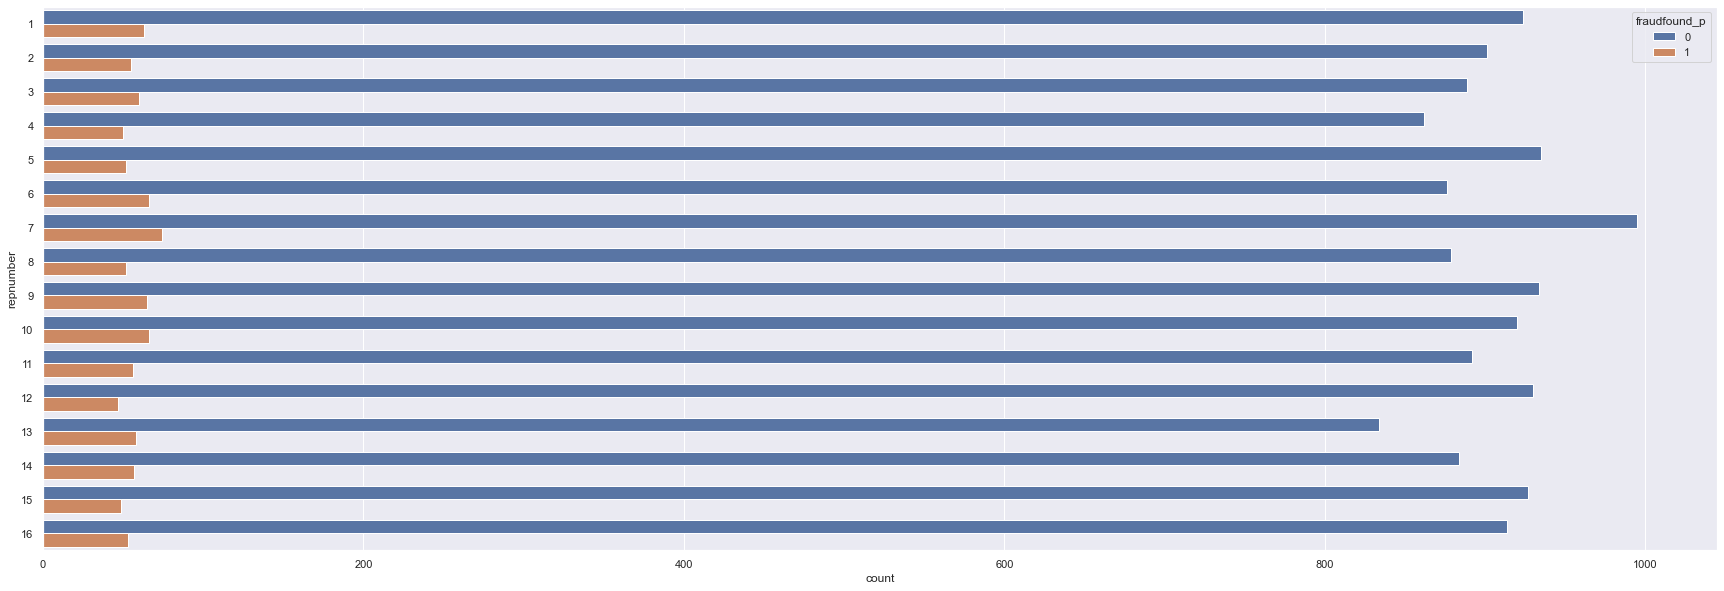

In [159]:
ax = sns.countplot(y="repnumber", hue="fraudfound_p", data=data_modeling)

Esta variable puede no ser interesante dado que este numero de reporte parece ser un número que se asigna entre 1 y 16, habria que tener un poco más de contexto para definir si es importante agregarla o no.

* Fraude vs `deductible` (Costo del seguro)

In [160]:
Conteo=data_modeling[['deductible','fraudfound_p']].fillna('NA').value_counts().reset_index(name='Count')#.sort_values(['deductible', 'fraudfound_p'],ascending = [True, True])
Conteo['Total']=Conteo.groupby('deductible')['Count'].transform('sum')
Conteo['Porcentaje']=Conteo['Count']/Conteo['Total']*100
Conteo[Conteo['fraudfound_p']==1].sort_values(['Porcentaje'],ascending=False)

,deductible,fraudfound_p,Count,Total,Porcentaje
7,300,1,2,8,25.000000
4,500,1,47,263,17.870722
5,700,1,18,311,5.787781
1,400,1,856,14837,5.769360


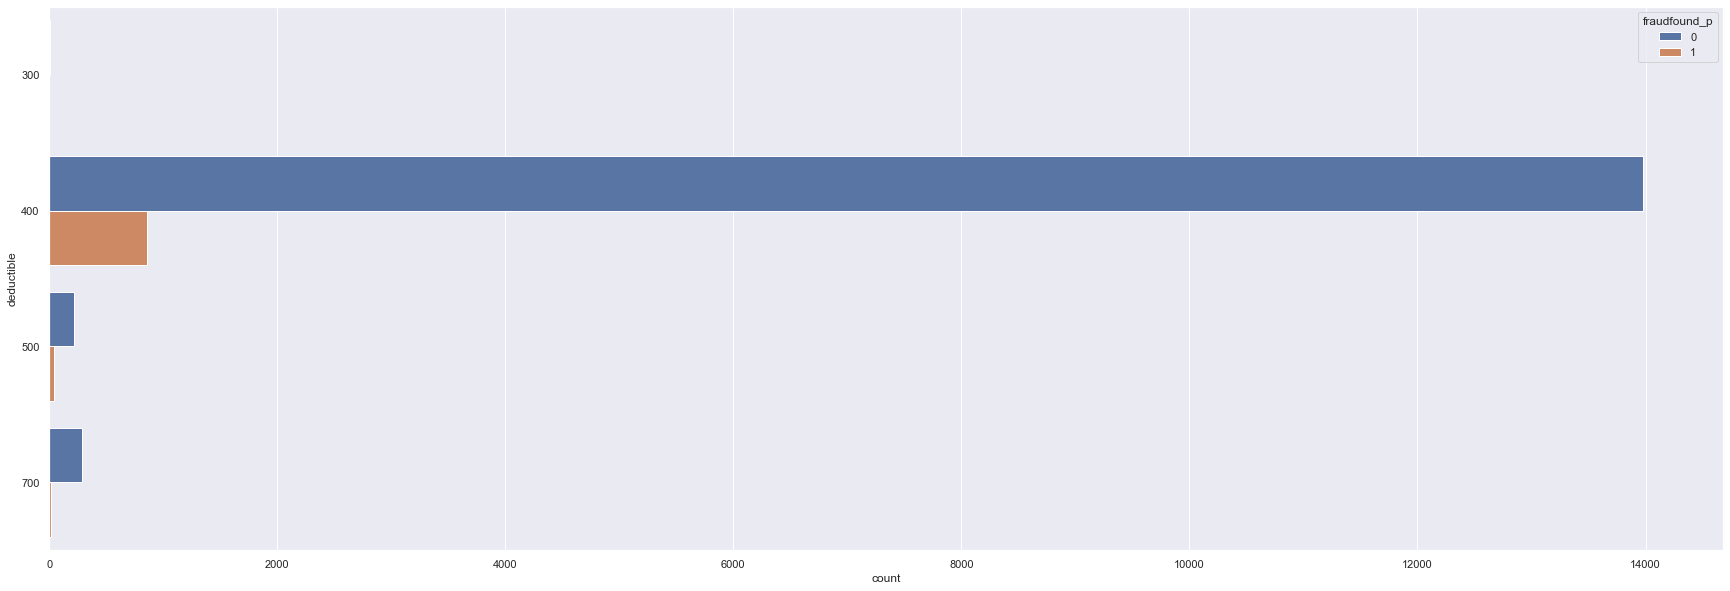

In [161]:
ax = sns.countplot(y="deductible", hue="fraudfound_p", data=data_modeling)

* Fraude vs `driverrating` (Calificación del piloto, puede ser data ordinal)

In [162]:
Conteo=data_modeling[['driverrating','fraudfound_p']].fillna('NA').value_counts().reset_index(name='Count')#.sort_values(['driverrating', 'fraudfound_p'],ascending = [True, True])
Conteo['Total']=Conteo.groupby('driverrating')['Count'].transform('sum')
Conteo['Porcentaje']=Conteo['Count']/Conteo['Total']*100
Conteo[Conteo['fraudfound_p']==1].sort_values(['Porcentaje'],ascending=False)

,driverrating,fraudfound_p,Count,Total,Porcentaje
4,3,1,242,3884,6.230690
5,4,1,235,3791,6.198892
6,1,1,232,3944,5.882353
7,2,1,214,3800,5.631579


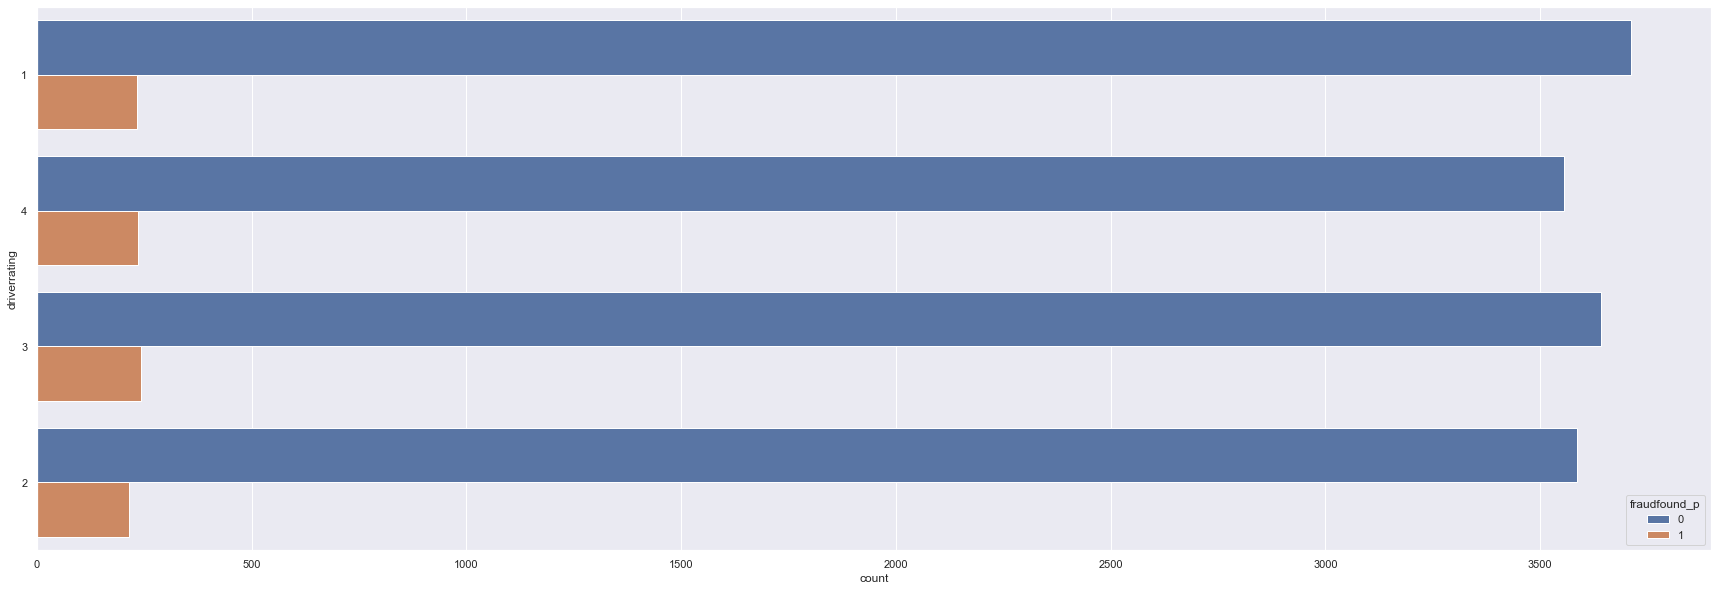

In [163]:
ax = sns.countplot(y="driverrating", hue="fraudfound_p", data=data_modeling)

* Fraude vs `days_policy_accident` (Rango adquisición del seguro y suceso del accidente)

In [164]:
Conteo=data_modeling[['days_policy_accident','fraudfound_p']].fillna('NA').value_counts().reset_index(name='Count')#.sort_values(['days_policy_accident', 'fraudfound_p'],ascending = [True, True])
Conteo['Total']=Conteo.groupby('days_policy_accident')['Count'].transform('sum')
Conteo['Porcentaje']=Conteo['Count']/Conteo['Total']*100
Conteo[Conteo['fraudfound_p']==1].sort_values(['Porcentaje'],ascending=False)

,days_policy_accident,fraudfound_p,Count,Total,Porcentaje
6,none,1,9,55,16.363636
7,8 to 15,1,5,55,9.090909
9,1 to 7,1,1,14,7.142857
8,15 to 30,1,3,49,6.122449
1,more than 30,1,905,15246,5.935983


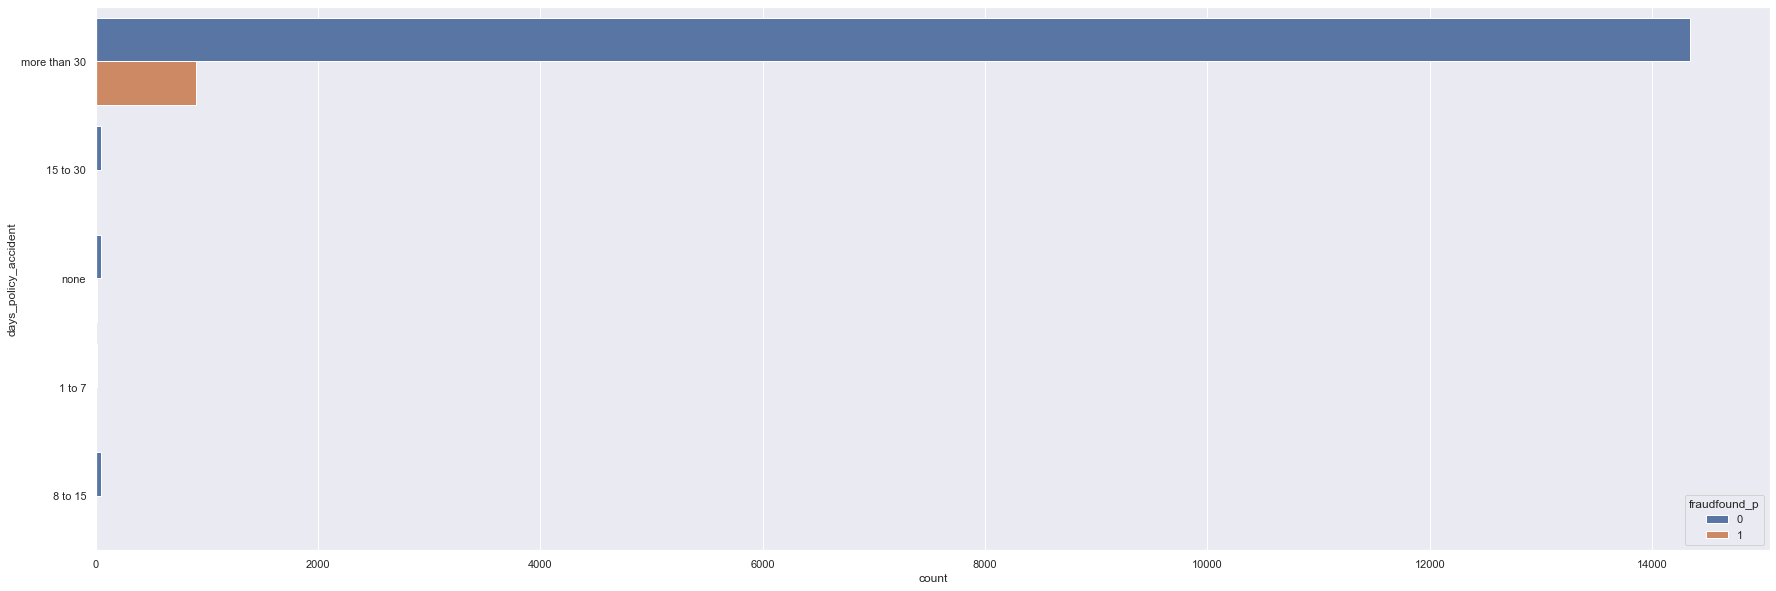

In [165]:
ax = sns.countplot(y="days_policy_accident", hue="fraudfound_p", data=data_modeling)

* Fraude vs `days_policy_claim` (Rango entre adquisición del seguro y denuncia del accidente)

In [166]:
Conteo=data_modeling[['days_policy_claim','fraudfound_p']].fillna('NA').value_counts().reset_index(name='Count')#.sort_values(['days_policy_claim', 'fraudfound_p'],ascending = [True, True])
Conteo['Total']=Conteo.groupby('days_policy_claim')['Count'].transform('sum')
Conteo['Porcentaje']=Conteo['Count']/Conteo['Total']*100
Conteo[Conteo['fraudfound_p']==1].sort_values(['Porcentaje'],ascending=False)

,days_policy_claim,fraudfound_p,Count,Total,Porcentaje
5,8 to 15,1,3,21,14.285714
4,15 to 30,1,6,56,10.714286
1,more than 30,1,914,15342,5.957502


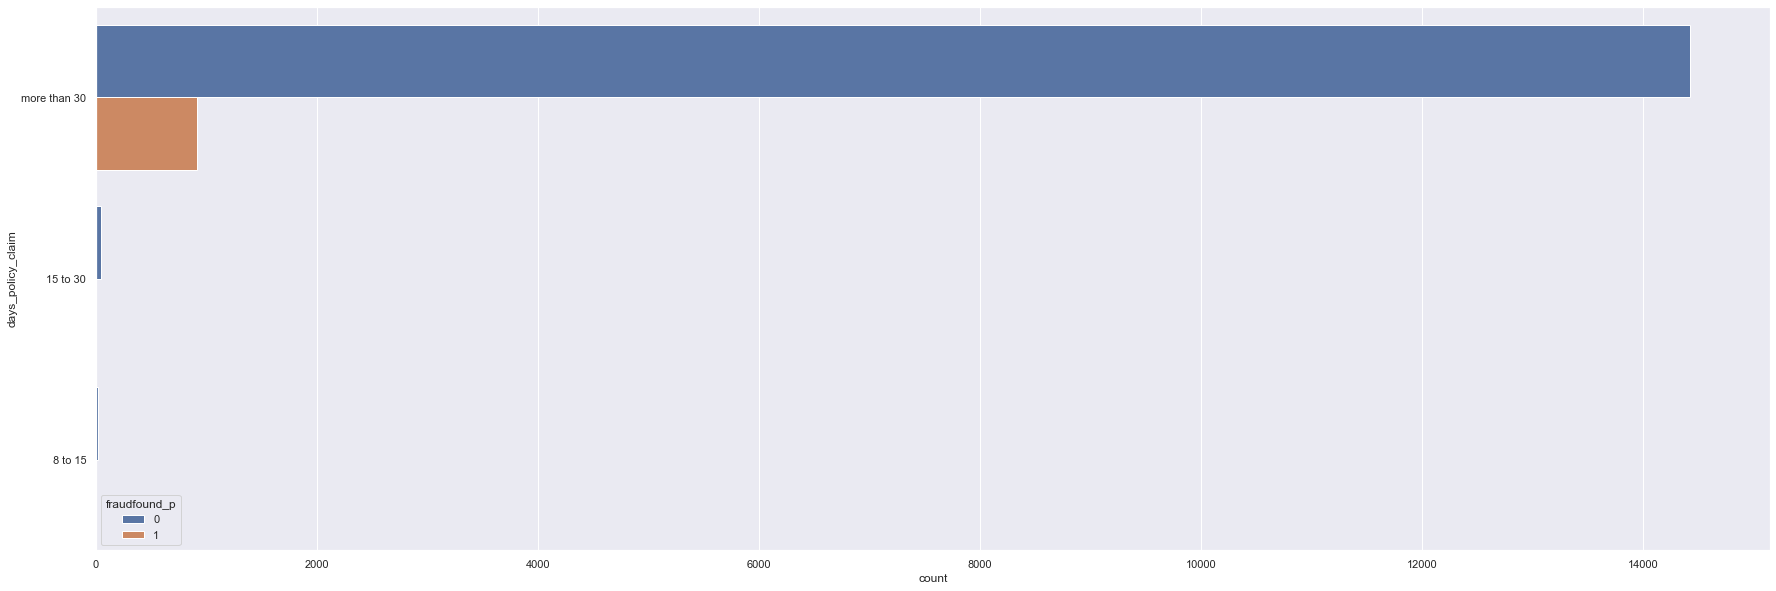

In [167]:
ax = sns.countplot(y="days_policy_claim", hue="fraudfound_p", data=data_modeling)

* Fraude vs `pastnumberofclaims` (Cantidad de denuncias anteriores realizadas por el dueño del vehículo)

In [168]:
Conteo=data_modeling[['pastnumberofclaims','fraudfound_p']].fillna('NA').value_counts().reset_index(name='Count')#.sort_values(['pastnumberofclaims', 'fraudfound_p'],ascending = [True, True])
Conteo['Total']=Conteo.groupby('pastnumberofclaims')['Count'].transform('sum')
Conteo['Porcentaje']=Conteo['Count']/Conteo['Total']*100
Conteo[Conteo['fraudfound_p']==1].sort_values(['Porcentaje'],ascending=False)

,pastnumberofclaims,fraudfound_p,Count,Total,Porcentaje
4,none,1,339,4351,7.791312
6,1,1,222,3573,6.213266
5,2 to 4,1,294,5485,5.360073
7,more than 4,1,68,2010,3.383085


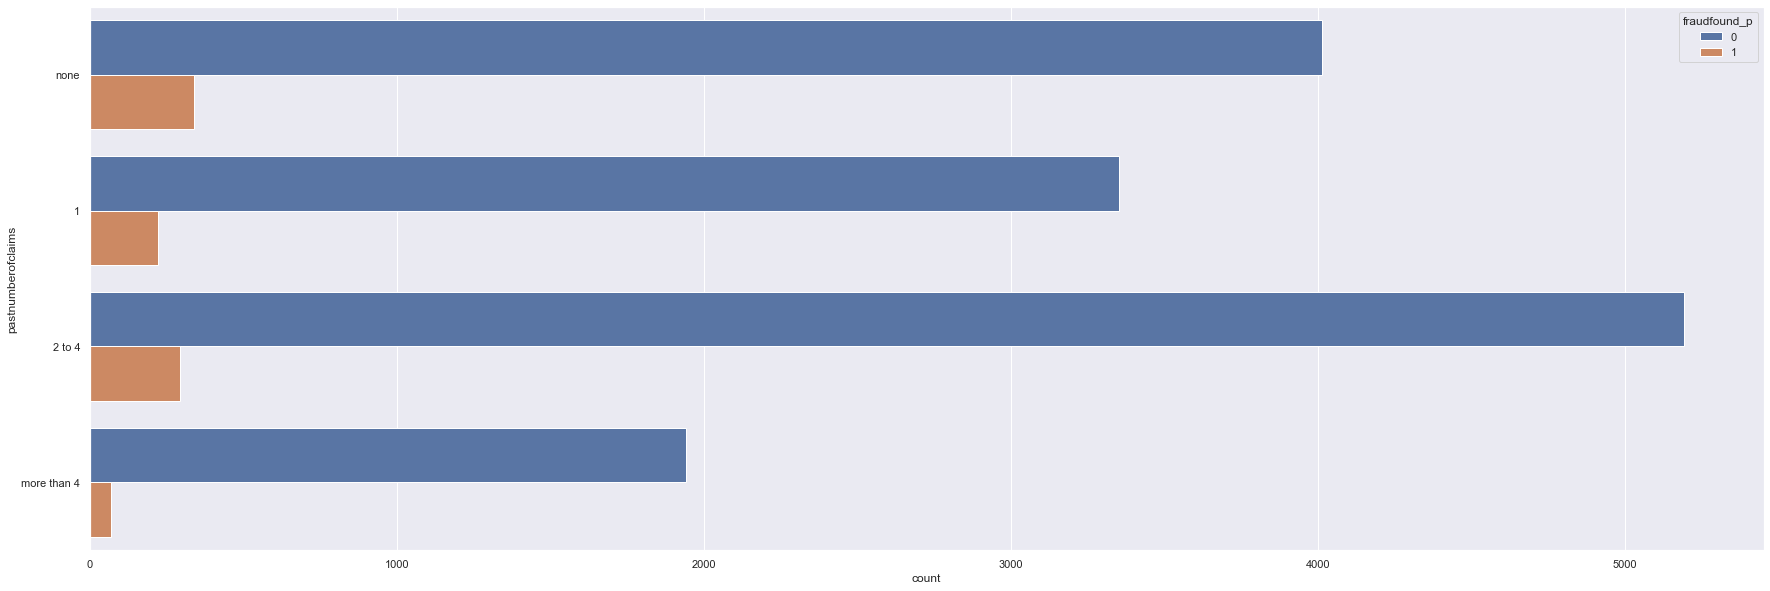

In [169]:
ax = sns.countplot(y="pastnumberofclaims", hue="fraudfound_p", data=data_modeling)

* Fraude vs `ageofvehicle` (Edad del vehículo)

In [170]:
Conteo=data_modeling[['ageofvehicle','fraudfound_p']].fillna('NA').value_counts().reset_index(name='Count')#.sort_values(['ageofvehicle', 'fraudfound_p'],ascending = [True, True])
Conteo['Total']=Conteo.groupby('ageofvehicle')['Count'].transform('sum')
Conteo['Porcentaje']=Conteo['Count']/Conteo['Total']*100
Conteo[Conteo['fraudfound_p']==1].sort_values(['Porcentaje'],ascending=False)

,ageofvehicle,fraudfound_p,Count,Total,Porcentaje
13,4 years,1,21,229,9.170306
12,new,1,32,372,8.602151
14,3 years,1,13,152,8.552632
10,5 years,1,95,1357,7.000737
6,6 years,1,228,3448,6.612529
5,7 years,1,325,5807,5.596694
8,more than 7,1,206,3981,5.174579
15,2 years,1,3,73,4.109589


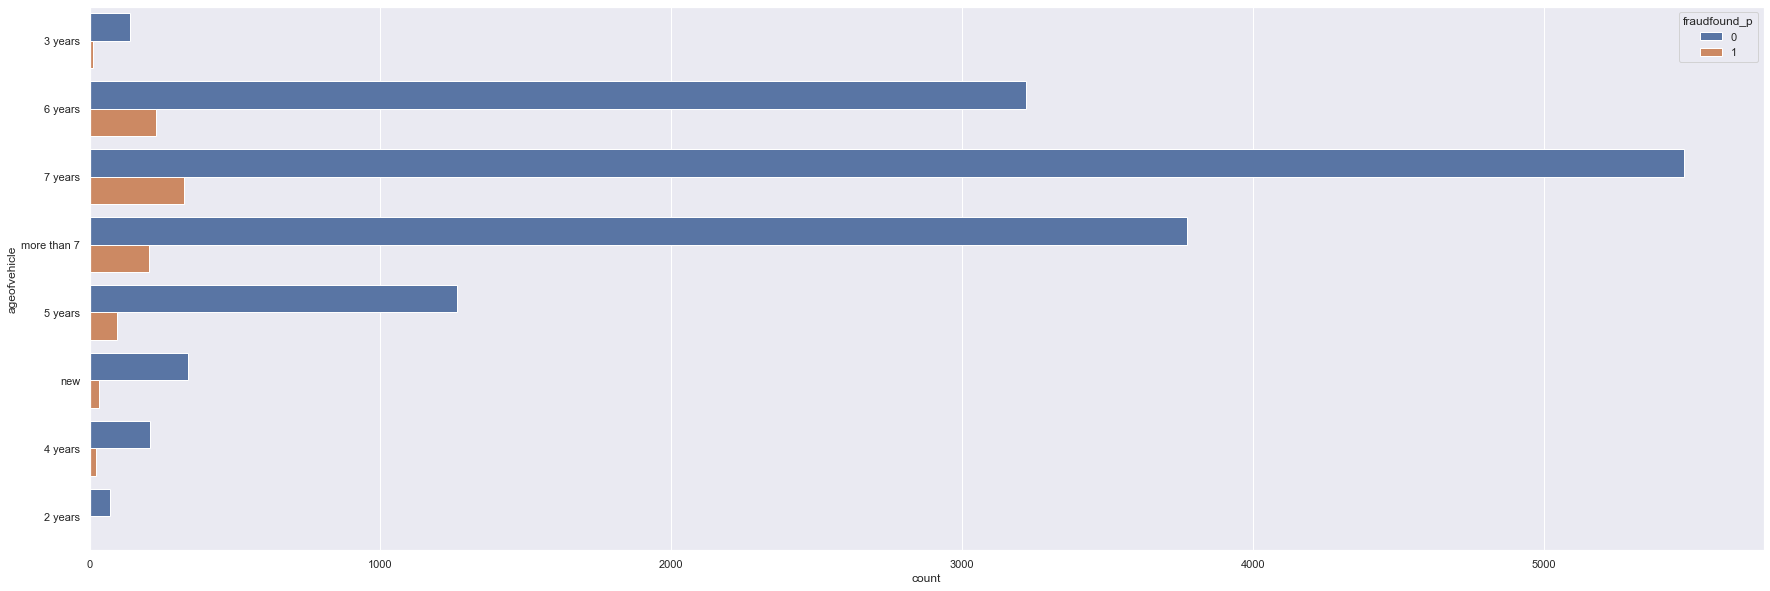

In [171]:
ax = sns.countplot(y="ageofvehicle", hue="fraudfound_p", data=data_modeling)

* Fraude vs `ageofpolicyholder` (Edad del dueño del seguro)

In [172]:
Conteo=data_modeling[['ageofpolicyholder','fraudfound_p']].fillna('NA').value_counts().reset_index(name='Count')#.sort_values(['ageofpolicyholder', 'fraudfound_p'],ascending = [True, True])
Conteo['Total']=Conteo.groupby('ageofpolicyholder')['Count'].transform('sum')
Conteo['Porcentaje']=Conteo['Count']/Conteo['Total']*100
Conteo[Conteo['fraudfound_p']==1].sort_values(['Porcentaje'],ascending=False)

,ageofpolicyholder,fraudfound_p,Count,Total,Porcentaje
15,21 to 25,1,16,108,14.814815
17,18 to 20,1,2,15,13.333333
13,16 to 17,1,31,319,9.717868
6,31 to 35,1,360,5593,6.436617
14,over 65,1,30,508,5.905512
8,36 to 40,1,237,4043,5.861984
12,26 to 30,1,33,613,5.383361
9,41 to 50,1,144,2828,5.091938
11,51 to 65,1,70,1392,5.028736


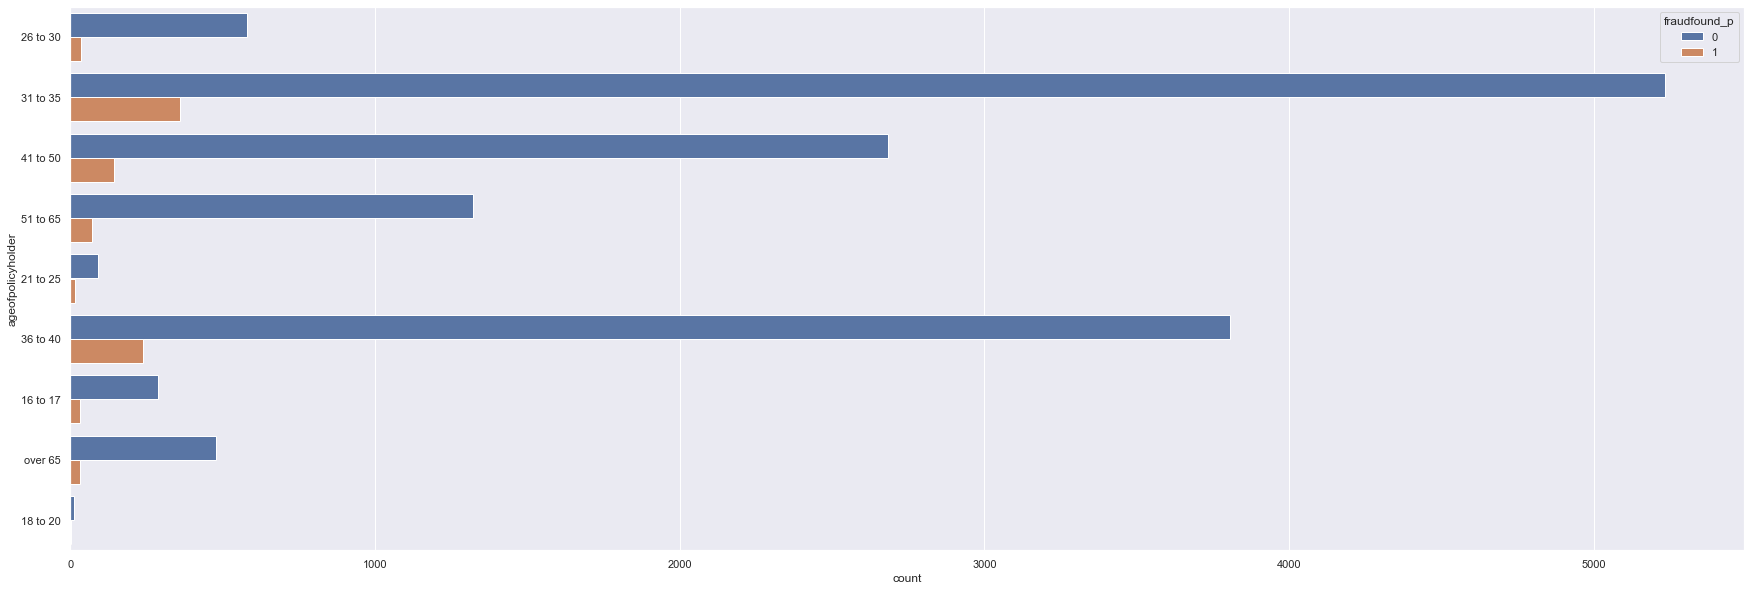

In [173]:
ax = sns.countplot(y="ageofpolicyholder", hue="fraudfound_p", data=data_modeling)

* Fraude vs `policereportfiled` ( Si fue denunciado a la policía)

In [174]:
Conteo=data_modeling[['policereportfiled','fraudfound_p']].fillna('NA').value_counts().reset_index(name='Count')#.sort_values(['policereportfiled', 'fraudfound_p'],ascending = [True, True])
Conteo['Total']=Conteo.groupby('policereportfiled')['Count'].transform('sum')
Conteo['Porcentaje']=Conteo['Count']/Conteo['Total']*100
Conteo[Conteo['fraudfound_p']==1].sort_values(['Porcentaje'],ascending=False)

,policereportfiled,fraudfound_p,Count,Total,Porcentaje
1,No,1,907,14991,6.050297
3,Yes,1,16,428,3.738318


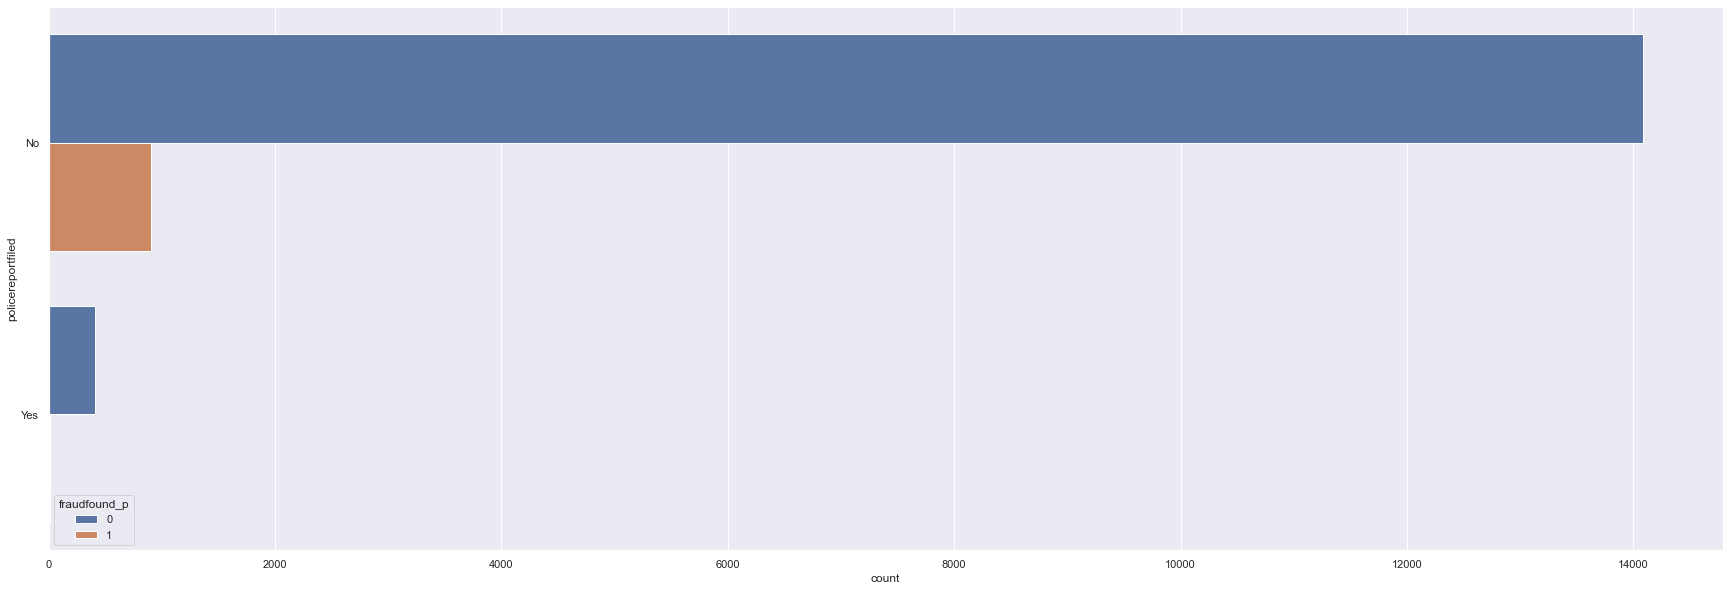

In [175]:
ax = sns.countplot(y="policereportfiled", hue="fraudfound_p", data=data_modeling)

* Fraude vs `witnesspresent` (Si hay testigos)

In [176]:
Conteo=data_modeling[['witnesspresent','fraudfound_p']].fillna('NA').value_counts().reset_index(name='Count')#.sort_values(['witnesspresent', 'fraudfound_p'],ascending = [True, True])
Conteo['Total']=Conteo.groupby('witnesspresent')['Count'].transform('sum')
Conteo['Porcentaje']=Conteo['Count']/Conteo['Total']*100
Conteo[Conteo['fraudfound_p']==1].sort_values(['Porcentaje'],ascending=False)

,witnesspresent,fraudfound_p,Count,Total,Porcentaje
1,No,1,920,15332,6.000522
3,Yes,1,3,87,3.448276


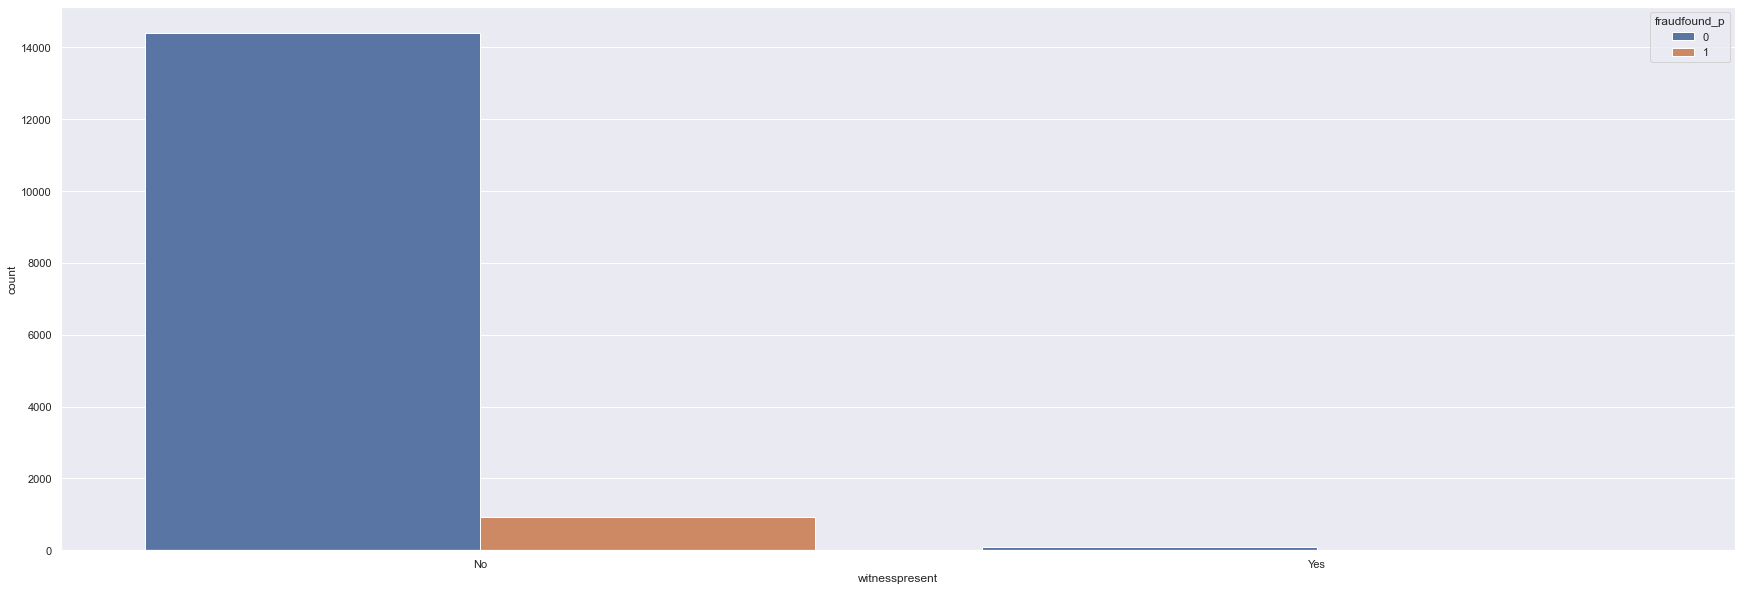

In [177]:
ax = sns.countplot(x="witnesspresent", hue="fraudfound_p", data=data_modeling)

Muy bajos porcentajes de `Yes`, para la variable `witnesspresent`  

* Fraude vs `agenttype` (Internos son cuando el fraude es realizado por personas trabajando en la empresa de seguros. Externos son los fraudes en los que el seguro es engañado por personas independientes)

In [178]:
Conteo=data_modeling[['agenttype','fraudfound_p']].fillna('NA').value_counts().reset_index(name='Count')#.sort_values(['agenttype', 'fraudfound_p'],ascending = [True, True])
Conteo['Total']=Conteo.groupby('agenttype')['Count'].transform('sum')
Conteo['Porcentaje']=Conteo['Count']/Conteo['Total']*100
Conteo[Conteo['fraudfound_p']==1].sort_values(['Porcentaje'],ascending=False)

,agenttype,fraudfound_p,Count,Total,Porcentaje
1,External,1,919,15178,6.054816
3,Internal,1,4,241,1.659751


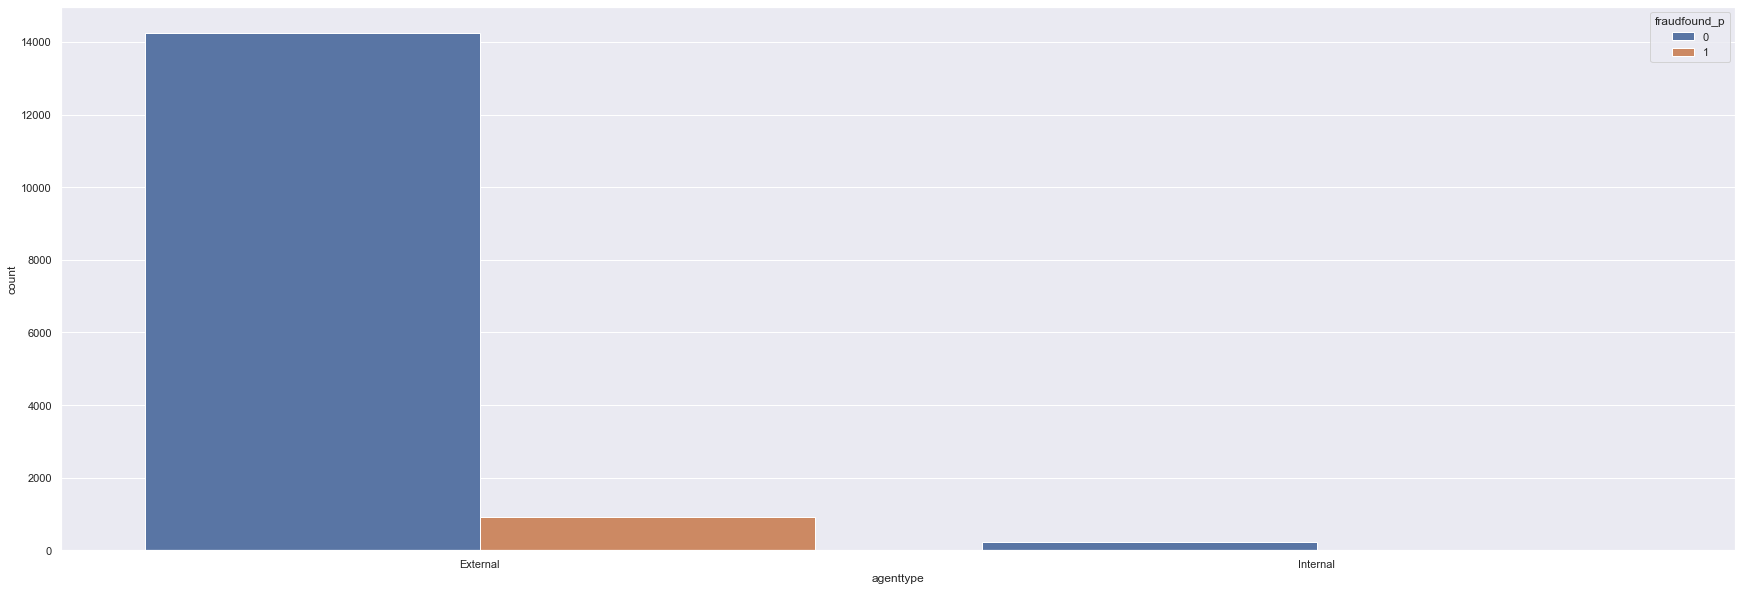

In [179]:
ax = sns.countplot(x="agenttype", hue="fraudfound_p", data=data_modeling)

* Fraude vs `numberofsuppliments` (Son daños al vehículo no registrados a la hora de la denuncia, daños extras que no se ven por el exterior, normalmente roturas en componentes internos como suspensión, chasis, etc.)

In [180]:
Conteo=data_modeling[['numberofsuppliments','fraudfound_p']].fillna('NA').value_counts().reset_index(name='Count')#.sort_values(['numberofsuppliments', 'fraudfound_p'],ascending = [True, True])
Conteo['Total']=Conteo.groupby('numberofsuppliments')['Count'].transform('sum')
Conteo['Porcentaje']=Conteo['Count']/Conteo['Total']*100
Conteo[Conteo['fraudfound_p']==1].sort_values(['Porcentaje'],ascending=False)

,numberofsuppliments,fraudfound_p,Count,Total,Porcentaje
4,none,1,472,7046,6.698836
6,1 to 2,1,159,2489,6.388108
5,more than 5,1,195,3867,5.042669
7,3 to 5,1,97,2017,4.809122


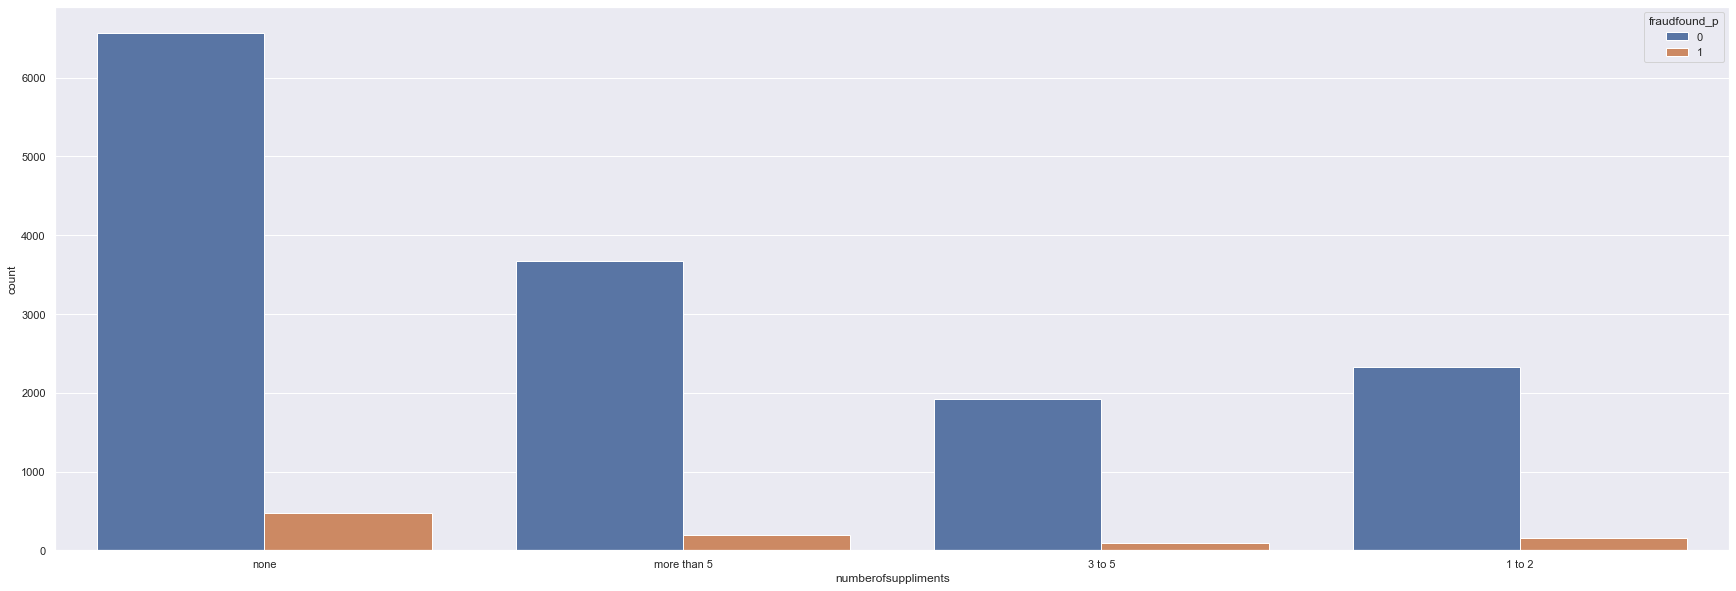

In [181]:
ax = sns.countplot(x="numberofsuppliments", hue="fraudfound_p", data=data_modeling)

* Fraude vs `addresschange_claim` ()

In [182]:
Conteo=data_modeling[['addresschange_claim','fraudfound_p']].fillna('NA').value_counts().reset_index(name='Count')#.sort_values(['addresschange_claim', 'fraudfound_p'],ascending = [True, True])
Conteo['Total']=Conteo.groupby('addresschange_claim')['Count'].transform('sum')
Conteo['Porcentaje']=Conteo['Count']/Conteo['Total']*100
Conteo[Conteo['fraudfound_p']==1].sort_values(['Porcentaje'],ascending=False)

,addresschange_claim,fraudfound_p,Count,Total,Porcentaje
8,under 6 months,1,3,4,75.000000
5,2 to 3 years,1,51,291,17.525773
7,1 year,1,11,170,6.470588
1,no change,1,825,14323,5.759966
6,4 to 8 years,1,33,631,5.229794


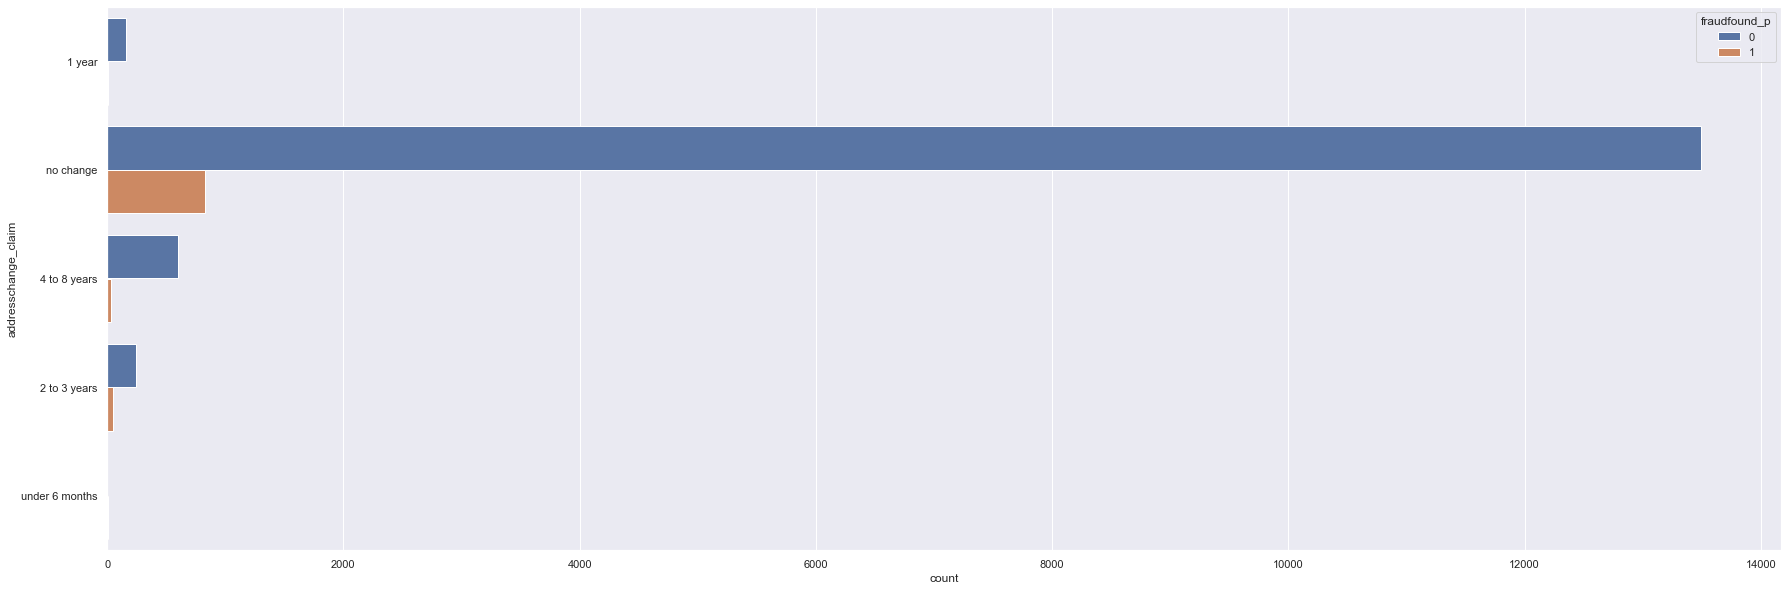

In [183]:
ax = sns.countplot(y="addresschange_claim", hue="fraudfound_p", data=data_modeling)

* Fraude vs `numberofcars` (Número de autos involucrados en el accidente)

In [184]:
Conteo=data_modeling[['numberofcars','fraudfound_p']].fillna('NA').value_counts().reset_index(name='Count')#.sort_values(['numberofcars', 'fraudfound_p'],ascending = [True, True])
Conteo['Total']=Conteo.groupby('numberofcars')['Count'].transform('sum')
Conteo['Porcentaje']=Conteo['Count']/Conteo['Total']*100
Conteo[Conteo['fraudfound_p']==1].sort_values(['Porcentaje'],ascending=False)

,numberofcars,fraudfound_p,Count,Total,Porcentaje
5,3 to 4,1,29,372,7.795699
4,2 vehicles,1,43,709,6.064880
1,1 vehicle,1,850,14315,5.937827
8,5 to 8,1,1,21,4.761905


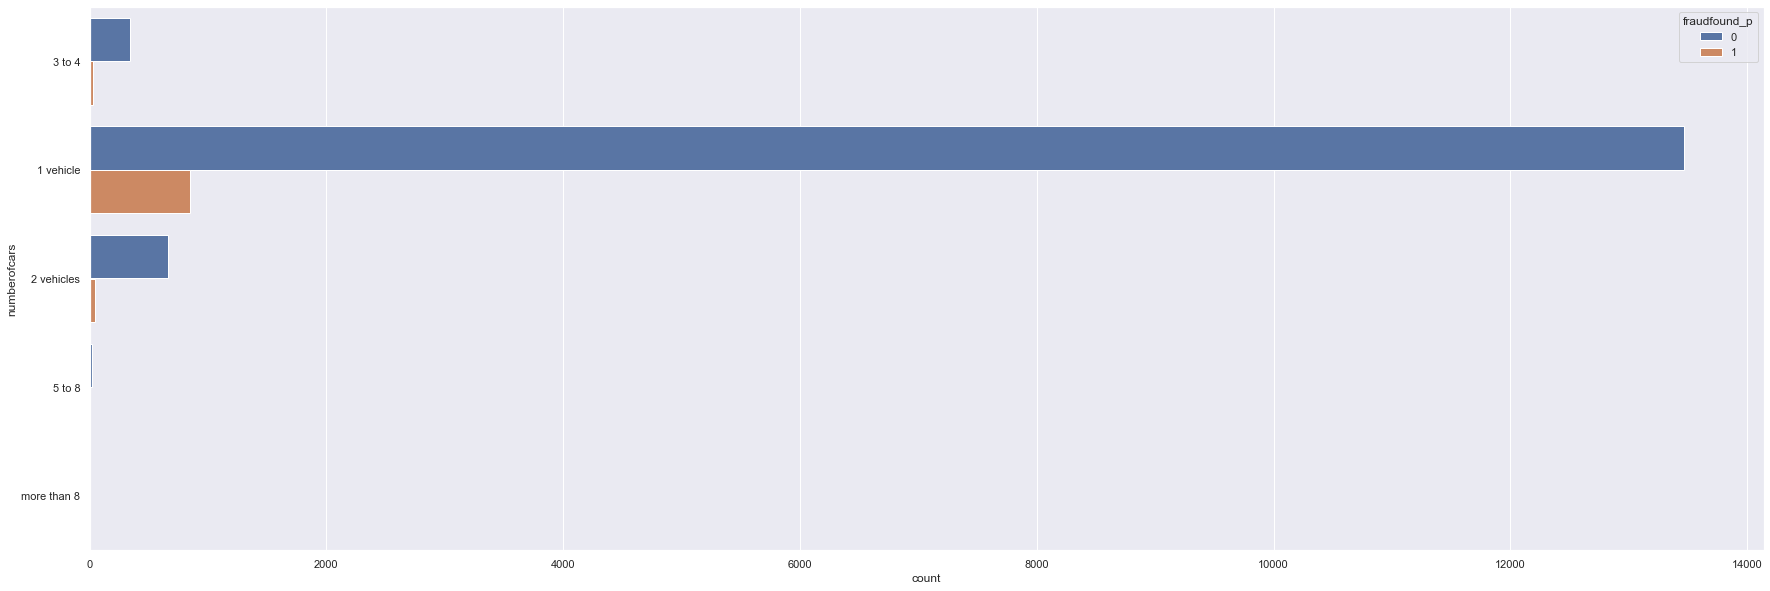

In [185]:
ax = sns.countplot(y="numberofcars", hue="fraudfound_p", data=data_modeling)

Los eventos se concentran en accidentes donde solo se ha involucrado 1 vehiculo

* Fraude vs `yearr` (Año en el que ocurrió el accidente)

In [186]:
Conteo=data_modeling[['yearr','fraudfound_p']].fillna('NA').value_counts().reset_index(name='Count')#.sort_values(['yearr', 'fraudfound_p'],ascending = [True, True])
Conteo['Total']=Conteo.groupby('yearr')['Count'].transform('sum')
Conteo['Porcentaje']=Conteo['Count']/Conteo['Total']*100
Conteo[Conteo['fraudfound_p']==1].sort_values(['Porcentaje'],ascending=False)

,yearr,fraudfound_p,Count,Total,Porcentaje
3,1994,1,409,6141,6.660153
4,1995,1,301,5195,5.794033
5,1996,1,213,4083,5.216752


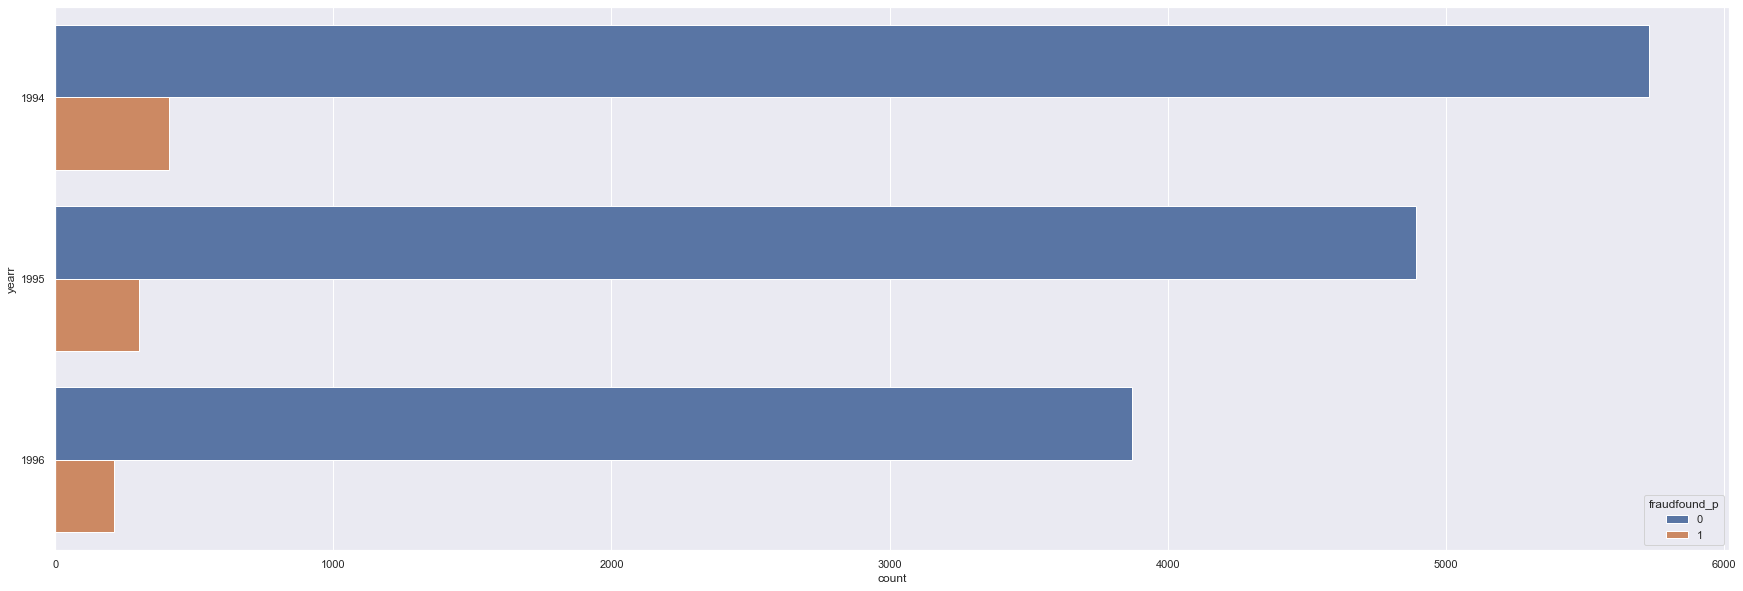

In [187]:
ax = sns.countplot(y="yearr", hue="fraudfound_p", data=data_modeling)

* Fraude vs `basepolicy` (Tipo de seguro, igual a PolicyType)

In [188]:
Conteo=data_modeling[['basepolicy','fraudfound_p']].fillna('NA').value_counts().reset_index(name='Count')#.sort_values(['basepolicy', 'fraudfound_p'],ascending = [True, True])
Conteo['Total']=Conteo.groupby('basepolicy')['Count'].transform('sum')
Conteo['Porcentaje']=Conteo['Count']/Conteo['Total']*100
Conteo[Conteo['fraudfound_p']==1].sort_values(['Porcentaje'],ascending=False)

,basepolicy,fraudfound_p,Count,Total,Porcentaje
3,All Perils,1,452,4448,10.161871
4,Collision,1,435,5962,7.296209
5,Liability,1,36,5009,0.718706


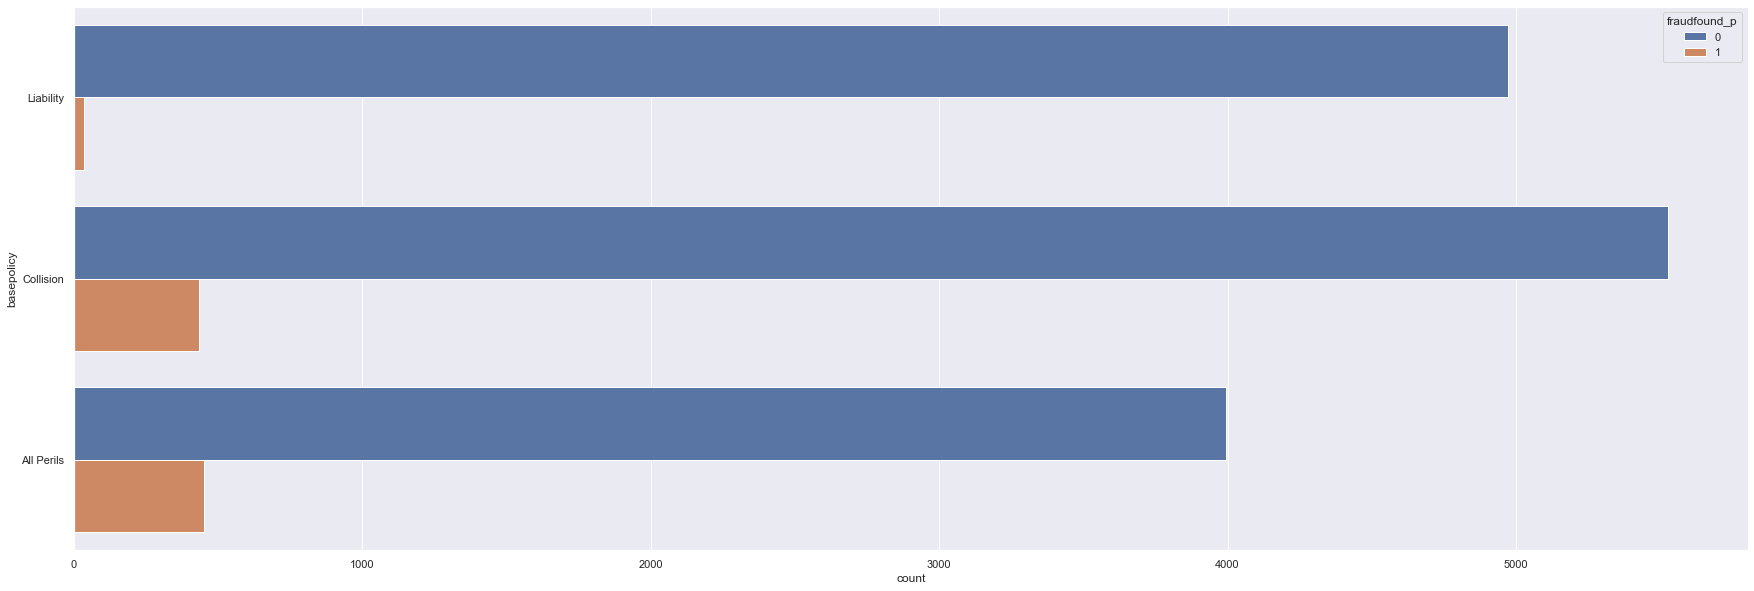

In [189]:
ax = sns.countplot(y="basepolicy", hue="fraudfound_p", data=data_modeling)

## Encoding Data

### Encoder

In [190]:
import category_encoders as ce
import pickle as pickle

In [191]:
colums_cuali = data_modeling.select_dtypes(include='object').columns
colums_cuali

Index(['monthh', 'weekofmonth', 'dayofweek', 'make', 'accidentarea',
       'dayofweekclaimed', 'monthclaimed', 'weekofmonthclaimed', 'sex',
       'maritalstatus', 'fault', 'policytype', 'vehiclecategory',
       'vehicleprice', 'driverrating', 'days_policy_accident',
       'days_policy_claim', 'pastnumberofclaims', 'ageofvehicle',
       'ageofpolicyholder', 'policereportfiled', 'witnesspresent', 'agenttype',
       'numberofsuppliments', 'addresschange_claim', 'numberofcars',
       'basepolicy'],
      dtype='object')

In [192]:
colums_cuanti= data_modeling.select_dtypes(exclude='object').columns
colums_cuanti

Index(['age', 'fraudfound_p', 'policynumber', 'repnumber', 'deductible',
       'yearr'],
      dtype='object')

In [193]:
dfa_cuali = data_modeling[colums_cuali]
dfa_cuanti = data_modeling[colums_cuanti]

In [194]:
dfa_cuanti

,age,fraudfound_p,policynumber,repnumber,deductible,yearr
0,21,0,1,12,300,1994
1,34,0,2,15,400,1994
2,47,0,3,7,400,1994
3,65,0,4,4,400,1994
4,27,0,5,3,400,1994
...,...,...,...,...,...,...
15415,35,1,15416,5,400,1996
15416,30,0,15417,11,400,1996
15417,24,1,15418,4,400,1996
15418,34,0,15419,6,400,1996


In [224]:
encoder=ce.OneHotEncoder(handle_unknown='ignore',return_df=True,use_cat_names=True,drop_invariant=True)
data_encoded = encoder.fit(data_modeling)
data_encoded

OneHotEncoder(cols=['monthh', 'weekofmonth', 'dayofweek', 'make',
                    'accidentarea', 'dayofweekclaimed', 'monthclaimed',
                    'weekofmonthclaimed', 'sex', 'maritalstatus', 'fault',
                    'policytype', 'vehiclecategory', 'vehicleprice',
                    'driverrating', 'days_policy_accident', 'days_policy_claim',
                    'pastnumberofclaims', 'ageofvehicle', 'ageofpolicyholder',
                    'policereportfiled', 'witnesspresent', 'agenttype',
                    'numberofsuppliments', 'addresschange_claim',
                    'numberofcars', 'basepolicy'],
              drop_invariant=True, handle_unknown='ignore', use_cat_names=True)

In [225]:
dfa_encoder = data_encoded.transform(data_modeling)
dfa_encoder

,monthh_Dec,monthh_Jan,monthh_Oct,monthh_Jun,monthh_Feb,...,numberofcars_more than 8,yearr,basepolicy_Liability,basepolicy_Collision,basepolicy_All Perils
0,1,0,0,0,0,...,0,1994,1,0,0
1,0,1,0,0,0,...,0,1994,0,1,0
2,0,0,1,0,0,...,0,1994,0,1,0
3,0,0,0,1,0,...,0,1994,1,0,0
4,0,1,0,0,0,...,0,1994,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
15415,0,0,0,0,0,...,0,1996,0,1,0
15416,0,0,0,0,0,...,0,1996,1,0,0
15417,0,0,0,0,0,...,0,1996,0,1,0
15418,1,0,0,0,0,...,0,1996,0,0,1


In [226]:
data_encoded.get_params

<bound method BaseEstimator.get_params of OneHotEncoder(cols=['monthh', 'weekofmonth', 'dayofweek', 'make',
                    'accidentarea', 'dayofweekclaimed', 'monthclaimed',
                    'weekofmonthclaimed', 'sex', 'maritalstatus', 'fault',
                    'policytype', 'vehiclecategory', 'vehicleprice',
                    'driverrating', 'days_policy_accident', 'days_policy_claim',
                    'pastnumberofclaims', 'ageofvehicle', 'ageofpolicyholder',
                    'policereportfiled', 'witnesspresent', 'agenttype',
                    'numberofsuppliments', 'addresschange_claim',
                    'numberofcars', 'basepolicy'],
              drop_invariant=True, handle_unknown='ignore', use_cat_names=True)>

In [227]:
with open("encode_final_pkl", "wb") as f: 
    pickle.dump(data_encoded, f)

In [228]:
encoder_load = pickle.load(open('encode_final', "rb"))

In [229]:
data_encoder=encoder_load.transform(data_modeling)

In [230]:
data_encoder.to_parquet('data_encoder.parquet')

In [231]:
#pip install pyarrow
#pip install fastparquet

## Conclusiones

* Se revisaron las variables encontrando algunos errores en los valores de estas
* Se puede realizar construcción de variables interesantes como número de fraudes del mes anterior, para ser utilizada como variable predictora
* Se encontraron variables que pueden ser relevantes en el modelo como: 

    *	`Make`: Marca del vehiculo
    *   `addresschange_claim`: Si ha cambiado la direncción de residencia en determinado rango de tiempo
    *	`basepolicy` (Tipo de seguro)
    *   `PolicyType`
    * `vehiclecategory`

* Se realizo el encoding de los datos, el cual puede ser usado en producción, para la transformación de la data extraida via postgresql